# 2048 Deep Reinforcement Learning

### Import Required Libraries

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
from copy import deepcopy
import random 
import math
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


### Game Logic

In [2]:
#initialize a new game
def new_game(n):
    matrix = np.zeros([n,n])
    return matrix

#add 2 or 4 in the matrix
def add_two(mat):
    empty_cells = []
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if(mat[i][j]==0):
                empty_cells.append((i,j))
    if(len(empty_cells)==0):
        return mat
    
    index_pair = empty_cells[random.randint(0,len(empty_cells)-1)]
    
    prob = random.random()
    if(prob>=0.9):
        mat[index_pair[0]][index_pair[1]]=4
    else:
        mat[index_pair[0]][index_pair[1]]=2
    return mat

#to check state of the game
def game_state(mat):
    #if 2048 in mat:
    #    return 'win'
    
    for i in range(len(mat)-1): #intentionally reduced to check the row on the right and below
        for j in range(len(mat[0])-1): #more elegant to use exceptions but most likely this will be their solution
            if mat[i][j]==mat[i+1][j] or mat[i][j+1]==mat[i][j]:
                return 'not over'
            
    for i in range(len(mat)): #check for any zero entries
        for j in range(len(mat[0])):
            if mat[i][j]==0:
                return 'not over'
            
    for k in range(len(mat)-1): #to check the left/right entries on the last row
        if mat[len(mat)-1][k]==mat[len(mat)-1][k+1]:
            return 'not over'
        
    for j in range(len(mat)-1): #check up/down entries on last column
        if mat[j][len(mat)-1]==mat[j+1][len(mat)-1]:
            return 'not over'
        
    return 'lose'


def reverse(mat):
    # reverse member of rows in mat
    # testmat = [[1,2,3,4],[5,6,7,8]]
    # revmat =reverse(testmat) # [[4,3,2,1],[8,7,6,5]]
    new=[]
    for i in range(len(mat)):
        new.append([])
        for j in range(len(mat[0])):
            new[i].append(mat[i][len(mat[0])-j-1])
    return new

def transpose(mat):
    # transpose
    # testmat = [[1,2,3,4],[5,6,7,8]]
    # [[1 5]
    # [2 6]
    # [3 7]
    # [4 8]]  
    return np.transpose(mat)

def cover_up(mat):
    # retval
    # new: new matrix which has all 0 in each row shifted to left
    # done: true if new matrix different from mat
    
    new = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    done = False
    for i in range(len(mat)):
        count = 0
        for j in range(len(mat[i])):
            if mat[i][j]!=0:
                new[i][count] = mat[i][j]
                if j!=count:
                    done=True
                count+=1
    return (new,done)

def merge(mat):
    done=False
    score = 0
    for i in range(4):
        for j in range(3):
            if mat[i][j]==mat[i][j+1] and mat[i][j]!=0:
                mat[i][j]*=2
                score += mat[i][j]   
                mat[i][j+1]=0
                done=True
    return (mat,done,score)

#up move
def up(game):
        game = transpose(game)
        game,done = cover_up(game)
        temp = merge(game)
        game = temp[0]
        done = done or temp[1]
        game = cover_up(game)[0]
        game = transpose(game)
        return (game,done,temp[2])

#down move
def down(game):
        game=reverse(transpose(game))
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        game=transpose(reverse(game))
        return (game,done,temp[2])

#left move
def left(game):
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        return (game,done,temp[2])

#right move
def right(game):
        game=reverse(game)
        game,done=cover_up(game)
        temp=merge(game)
        game=temp[0]
        done=done or temp[1]
        game=cover_up(game)[0]
        game=reverse(game)
        return (game,done,temp[2])

### Controls

In [3]:
controls = {0:up,1:left,2:right,3:down}

### Important Functions
* Find Empty Cell Function (Used in Reward)
* Convert Input Values

In [4]:
#convert the input game matrix into corresponding power of 2 matrix.
def change_values(X):
    power_mat = np.zeros(shape=(1,4,4,16),dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if(X[i][j]==0):
                power_mat[0][i][j][0] = 1.0
            else:
                power = int(math.log(X[i][j],2))
                power_mat[0][i][j][power] = 1.0
    return power_mat        

#find the number of empty cells in the game matrix.
def findemptyCell(mat):
    count = 0
    for i in range(len(mat)):
        for j in range(len(mat)):
            if(mat[i][j]==0):
                count+=1
    return count

### Hyper Parameters

In [5]:
#hyper parameters
start_learning_rate = 0.0005

#gamma for Q-learning
gamma = 0.9

#epsilon greedy approach
epsilon = 0.9

#to store states and lables of the game for training
#states of the game
replay_memory = list()

#labels of the states
replay_labels = list()

#capacity of memory
mem_capacity = 6000

### Network Architecture

![](https://github.com/navjindervirdee/2048-deep-reinforcement-learning/blob/master/Architecture/Architecture.JPG?raw=true)

In [6]:
#first convolution layer depth
depth1 = 256

#second convolution layer depth
depth2 = 128

#batch size for batch gradient descent
batch_size = 512

#input units
input_units = 16
input_depth = input_units

#fully connected layer neurons
hidden_units = 256

#output neurons = number of moves
output_units = 4

conv1_layer1_shape = [1,2,input_units,depth1]
conv1_layer2_shape = [1,2,depth1,depth2]
conv2_layer1_shape = [2,1,input_units,depth1]
conv2_layer2_shape = [2,1,depth1,depth2]

fc_layer1_w_shape = [3*4*depth1*2+ 4*2*depth2*2 + 3*3*depth2*2,hidden_units]
fc_layer1_b_shape = [hidden_units]
fc_layer2_w_shape = [hidden_units,output_units]
fc_layer2_b_shape = [output_units]

### Let's make the Tensorflow Graph
* Loss = mean ( square( Q(st,at) - (r + gamma x max(Q(st+1,a))) ) )
* Activation = RELU
* Optimizer = RMSProp

In [7]:
#input data
tf_batch_dataset = tf.placeholder(tf.float32,shape=(batch_size,4,4,16))
tf_batch_labels  = tf.placeholder(tf.float32,shape=(batch_size,output_units))

single_dataset   = tf.placeholder(tf.float32,shape=(1,4,4,16))

#CONV LAYERS
#conv layer1 weights
# conv1_layer1_weights = tf.Variable(tf.truncated_normal([1,2,input_units,depth1],mean=0,stddev=0.01), name='conv1_layer1_weights')
# conv2_layer1_weights = tf.Variable(tf.truncated_normal([2,1,input_units,depth1],mean=0,stddev=0.01), name='conv2_layer1_weights')

# conv layer2 weights
# conv1_layer2_weights = tf.Variable(tf.truncated_normal([1,2,depth1,depth2],mean=0,stddev=0.01),name='conv1_layer2_weights')
# conv2_layer2_weights = tf.Variable(tf.truncated_normal([2,1,depth1,depth2],mean=0,stddev=0.01),name='conv2_layer2_weights')
 
#FUllY CONNECTED LAYERS
expand_size = 2*4*depth2*2 + 3*3*depth2*2 + 4*3*depth1*2
# fc_layer1_weights = tf.Variable(tf.truncated_normal([expand_size,hidden_units],mean=0,stddev=0.01),name='fc_layer1_weights')
# fc_layer1_biases = tf.Variable(tf.truncated_normal([1,hidden_units],mean=0,stddev=0.01),name='fc_layer1_biases')
# fc_layer2_weights = tf.Variable(tf.truncated_normal([hidden_units,output_units],mean=0,stddev=0.01),name='fc_layer2_weights')
# fc_layer2_biases = tf.Variable(tf.truncated_normal([1,output_units],mean=0,stddev=0.01),name='fc_layer2_biases')

import os
import pandas as pd
THIS_FOLDER = os.path.abspath('')
PARENT_FOLDER = os.path.dirname(THIS_FOLDER)
WEIGHT_FOLDER = os.path.join(PARENT_FOLDER, 'ver2_result')
#conv layer1 weights

conv1_layer1_weights = tf.Variable(np.array(pd.read_csv(os.path.join(WEIGHT_FOLDER, 'conv1_layer1_weights.csv'))['Weight']).reshape(conv1_layer1_shape),dtype=tf.float32, name='conv1_layer1_weights')
conv2_layer1_weights = tf.Variable(np.array(pd.read_csv(os.path.join(WEIGHT_FOLDER, 'conv2_layer1_weights.csv'))['Weight']).reshape(conv2_layer1_shape),dtype=tf.float32, name='conv2_layer1_weights')

#conv layer2 weights
conv1_layer2_weights = tf.Variable(np.array(pd.read_csv(os.path.join(WEIGHT_FOLDER, 'conv1_layer2_weights.csv'))['Weight']).reshape(conv1_layer2_shape),dtype=tf.float32, name='conv1_layer2_weights')
conv2_layer2_weights = tf.Variable(np.array(pd.read_csv(os.path.join(WEIGHT_FOLDER, 'conv2_layer2_weights.csv'))['Weight']).reshape(conv2_layer2_shape),dtype=tf.float32, name='conv2_layer2_weights')

# FUllY CONNECTED LAYERS
fc_layer1_weights = tf.Variable(np.array(pd.read_csv(os.path.join(WEIGHT_FOLDER, 'fc_layer1_weights.csv'))['Weight']).reshape(fc_layer1_w_shape), dtype=tf.float32, name='fc_layer1_weights')
fc_layer1_biases = tf.Variable(np.array(pd.read_csv(os.path.join(WEIGHT_FOLDER, 'fc_layer1_biases.csv'))['Weight']).reshape(fc_layer1_b_shape), dtype=tf.float32, name='fc_layer1_biases.csv')
fc_layer2_weights = tf.Variable(np.array(pd.read_csv(os.path.join(WEIGHT_FOLDER, 'fc_layer2_weights.csv'))['Weight']).reshape(fc_layer2_w_shape), dtype=tf.float32, name='fc_layer2_weights')
fc_layer2_biases = tf.Variable(np.array(pd.read_csv(os.path.join(WEIGHT_FOLDER, 'fc_layer2_biases.csv'))['Weight']).reshape(fc_layer2_b_shape), dtype=tf.float32, name='fc_layer2_biases.csv')

def model(dataset):
    #layer1
    conv1 = tf.nn.conv2d(dataset,conv1_layer1_weights,[1,1,1,1],padding='VALID') 
    conv2 = tf.nn.conv2d(dataset,conv2_layer1_weights,[1,1,1,1],padding='VALID') 
    
    #layer1 relu activation
    relu1 = tf.nn.relu(conv1)
    relu2 = tf.nn.relu(conv2)
    
    #layer2
    conv11 = tf.nn.conv2d(relu1,conv1_layer2_weights,[1,1,1,1],padding='VALID') 
    conv12 = tf.nn.conv2d(relu1,conv2_layer2_weights,[1,1,1,1],padding='VALID') 

    conv21 = tf.nn.conv2d(relu2,conv1_layer2_weights,[1,1,1,1],padding='VALID') 
    conv22 = tf.nn.conv2d(relu2,conv2_layer2_weights,[1,1,1,1],padding='VALID') 

    #layer2 relu activation
    relu11 = tf.nn.relu(conv11)
    relu12 = tf.nn.relu(conv12)
    relu21 = tf.nn.relu(conv21)
    relu22 = tf.nn.relu(conv22)
    
    #get shapes of all activations
    shape1 = relu1.get_shape().as_list()
    shape2 = relu2.get_shape().as_list()
    
    shape11 = relu11.get_shape().as_list()
    shape12 = relu12.get_shape().as_list()
    shape21 = relu21.get_shape().as_list()
    shape22 = relu22.get_shape().as_list()

    #expansion
    hidden1 = tf.reshape(relu1,[shape1[0],shape1[1]*shape1[2]*shape1[3]])
    hidden2 = tf.reshape(relu2,[shape2[0],shape2[1]*shape2[2]*shape2[3]])
    
    hidden11 = tf.reshape(relu11,[shape11[0],shape11[1]*shape11[2]*shape11[3]])
    hidden12 = tf.reshape(relu12,[shape12[0],shape12[1]*shape12[2]*shape12[3]])
    hidden21 = tf.reshape(relu21,[shape21[0],shape21[1]*shape21[2]*shape21[3]])
    hidden22 = tf.reshape(relu22,[shape22[0],shape22[1]*shape22[2]*shape22[3]])

    #concatenation
    hidden = tf.concat([hidden1,hidden2,hidden11,hidden12,hidden21,hidden22],axis=1)

    #full connected layers
    hidden = tf.matmul(hidden,fc_layer1_weights) + fc_layer1_biases
    hidden = tf.nn.relu(hidden)

    #output layer
    output = tf.matmul(hidden,fc_layer2_weights) + fc_layer2_biases
    
    #return output
    return output

#for single example
single_output = model(single_dataset)

#for batch data
logits = model(tf_batch_dataset)

#loss
loss = tf.square(tf.subtract(tf_batch_labels,logits))
loss = tf.reduce_sum(loss,axis=1,keep_dims=True)
loss = tf.reduce_mean(loss)/2.0

#optimizer
global_step = tf.Variable(0,name='global_step')  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(float(start_learning_rate), global_step, 1000, 0.90, staircase=True)
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss, global_step=global_step)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
#loss
J = []

#scores
scores = []

#to store final parameters
final_parameters = {}
doublecheck_parameters = {}
#number of episodes
M = 4000

### Create training dataset and Train Simultaneously
* Current Reward = number of merges + log(new max,2)

In [9]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    for v in tf.trainable_variables():
        print(v.name[:-2])
        doublecheck_parameters[v.name[:-2]] = session.run(v)

conv1_layer1_weights
conv2_layer1_weights
conv1_layer2_weights
conv2_layer2_weights
fc_layer1_weights
fc_layer1_biases.csv
fc_layer2_weights
fc_layer2_biases.csv
global_step


In [10]:
print(doublecheck_parameters)

{'conv1_layer1_weights': array([[[[-0.00430916, -0.04614374, -0.00970056, ..., -0.07678066,
           0.03294034,  0.05858142],
         [ 0.02102926, -0.03341596, -0.01457464, ...,  0.03906241,
           0.00900546, -0.05467157],
         [ 0.03276553, -0.0068016 , -0.00592402, ...,  0.029501  ,
           0.01680852, -0.06207766],
         ...,
         [-0.01282583, -0.016788  , -0.00695734, ...,  0.00812065,
           0.00513653,  0.01100361],
         [ 0.01048076,  0.00077067, -0.00134941, ...,  0.00591641,
          -0.00939574, -0.01835553],
         [ 0.01184947,  0.01166494, -0.01882423, ...,  0.00098781,
          -0.00577846, -0.00492018]],

        [[ 0.03523835,  0.01165464, -0.00716036, ...,  0.01146713,
           0.01490038, -0.06049449],
         [ 0.03146661, -0.04500999, -0.00247524, ..., -0.03939667,
           0.0297108 , -0.06022599],
         [-0.01836944,  0.03224109, -0.00490449, ..., -0.01639565,
           0.01434602, -0.04852731],
         ...,
         

In [11]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    
    global epsilon
    global replay_labels
    global replay_memory

    #for episode with max score
    maximum = -1
    episode = -1
    
    #total_iters 
    total_iters = 1
    
    #number of back props
    back=0
    
    for ep in range(M):
        global board
        board = new_game(4)
        add_two(board)
        add_two(board)
        
        #whether episode finished or not
        finish = 'not over'
        
        #total_score of this episode
        total_score = 0
        
        #iters per episode
        local_iters = 1
        
        while(finish=='not over'):
            prev_board = deepcopy(board)
            
            #get the required move for this state
            state = deepcopy(board)
            state = change_values(state)
            state = np.array(state,dtype = np.float32).reshape(1,4,4,16)
            feed_dict = {single_dataset:state}
            control_scores = session.run(single_output,feed_dict=feed_dict)
            
            #find the move with max Q value
            control_buttons = np.flip(np.argsort(control_scores),axis=1)
            
            #copy the Q-values as labels
            labels = deepcopy(control_scores[0]) #somehow control_scores has the shape of [[a,b,c,d]]
            
            #generate random number for epsilon greedy approach
            num = random.uniform(0,1)
            
            #store prev max
            prev_max = np.max(prev_board)
            
            #num is less epsilon generate random move
            if(num<epsilon):
                #find legal moves
                legal_moves = list()
                for i in range(4):
                    temp_board = deepcopy(prev_board)
                    temp_board,_,_ = controls[i](temp_board)
                    if(np.array_equal(temp_board,prev_board)):
                        continue
                    else:
                        legal_moves.append(i)
                if(len(legal_moves)==0):
                    finish = 'lose'
                    continue
                
                #generate random move.
                random_move = random.sample(legal_moves,1)[0]
                
                #apply the move
                temp_state = deepcopy(prev_board)
                temp_state,_,score = controls[random_move](temp_state)
                total_score += score
                finish = game_state(temp_state)
                
                #get number of merges
                empty1 = findemptyCell(prev_board)
                empty2 = findemptyCell(temp_state)
                
                if(finish=='not over'):
                    temp_state = add_two(temp_state)

                board = deepcopy(temp_state)

                #get next max after applying the move
                next_max = np.max(temp_state)
                
                #reward math.log(next_max,2)*0.1 if next_max is higher than prev max
                labels[random_move] = (math.log(next_max,2))*0.1
                
                if(next_max==prev_max):
                    labels[random_move] = 0
                
                #reward is also the number of merges
                labels[random_move] += (empty2-empty1)
                
                #get the next state max Q-value
                temp_state = change_values(temp_state)
                temp_state = np.array(temp_state,dtype = np.float32).reshape(1,4,4,16)
                feed_dict = {single_dataset:temp_state}
                temp_scores = session.run(single_output,feed_dict=feed_dict)
                    
                max_qvalue = np.max(temp_scores)
                
                #final labels add gamma*max_qvalue
                labels[random_move] = (labels[random_move] + gamma*max_qvalue)
            
            #generate the the max predicted move
            else:
                for con in control_buttons[0]:
                    prev_state = deepcopy(prev_board)
                    
                    #apply the LEGAl Move with max q_value
                    temp_state,_,score = controls[con](prev_state)
                    
                    #if illegal move label = 0
                    if(np.array_equal(prev_board,temp_state)):
                        labels[con] = 0
                        continue
                        
                    #get number of merges
                    empty1 = findemptyCell(prev_board)
                    empty2 = findemptyCell(temp_state)

                    
                    temp_state = add_two(temp_state)
                    board = deepcopy(temp_state)
                    total_score += score

                    next_max = np.max(temp_state)
                    
                    #reward
                    labels[con] = (math.log(next_max,2))*0.1
                    if(next_max==prev_max):
                        labels[con] = 0
                    
                    labels[con] += (empty2-empty1)

                    #get next max qvalue
                    temp_state = change_values(temp_state)
                    temp_state = np.array(temp_state,dtype = np.float32).reshape(1,4,4,16)
                    feed_dict = {single_dataset:temp_state}
                    temp_scores = session.run(single_output,feed_dict=feed_dict)

                    max_qvalue = np.max(temp_scores)

                    #final labels
                    labels[con] = (labels[con] + gamma*max_qvalue)
                    break
                    
                if(np.array_equal(prev_board,board)):
                    finish = 'lose'
            
            #decrease the epsilon value
            if((ep>10000) or (epsilon>0.1 and total_iters%2500==0)):
                epsilon = epsilon/1.005
                
           
            #change the matrix values and store them in memory
            prev_state = deepcopy(prev_board)
            prev_state = change_values(prev_state)
            prev_state = np.array(prev_state,dtype=np.float32).reshape(1,4,4,16)
            replay_labels.append(labels)
            replay_memory.append(prev_state)
            
            
            #back-propagation
            if(len(replay_memory)>=mem_capacity):
                back_loss = 0
                batch_num = 0
                z = list(zip(replay_memory,replay_labels))
                np.random.shuffle(z)
                np.random.shuffle(z)
                replay_memory,replay_labels = zip(*z)
                
                for i in range(0,len(replay_memory),batch_size):
                    if(i + batch_size>len(replay_memory)):
                        break
                        
                    batch_data = deepcopy(replay_memory[i:i+batch_size])
                    batch_labels = deepcopy(replay_labels[i:i+batch_size])
                    
                    batch_data = np.array(batch_data,dtype=np.float32).reshape(batch_size,4,4,16)
                    batch_labels = np.array(batch_labels,dtype=np.float32).reshape(batch_size,output_units)
                
                    feed_dict = {tf_batch_dataset: batch_data, tf_batch_labels: batch_labels}
                    _,l = session.run([optimizer,loss],feed_dict=feed_dict)
                    back_loss += l 
                    
                    print("Mini-Batch - {} Back-Prop : {}, Loss : {}".format(batch_num,back,l))
                    batch_num +=1
                back_loss /= batch_num
                J.append(back_loss)
                
                #store the parameters in a dictionary
                final_parameters['conv1_layer1_weights'] = session.run(conv1_layer1_weights)
                final_parameters['conv2_layer1_weights'] = session.run(conv2_layer1_weights)
                final_parameters['fc_layer1_weights'] = session.run(fc_layer1_weights)
                final_parameters['fc_layer1_biases'] = session.run(fc_layer1_biases)
                
                for v in tf.trainable_variables():
                    doublecheck_parameters[v.name[:-2]] = session.run(v)
                    
                #number of back-props
                back+=1
                
                #make new memory 
                replay_memory = list()
                replay_labels = list()
                
            
            if(local_iters%400==0):
                print("Episode : {}, Score : {}, Iters : {}, Finish : {}".format(ep,total_score,local_iters,finish))
            
            local_iters += 1
            total_iters += 1
            
        scores.append(total_score)
        print("Episode {} finished with score {}, result : {} board : {}, epsilon  : {}, learning rate : {} ".format(ep,total_score,finish,board,epsilon,session.run(learning_rate)))
        print()
        
        if((ep+1)%1000==0):
            print("Maximum Score : {} ,Episode : {}".format(maximum,episode))    
            print("Loss : {}".format(J[len(J)-1]))
            print()
            
        if(maximum<total_score):
            maximum = total_score
            episode = ep
    print("Maximum Score : {} ,Episode : {}".format(maximum,episode))    

Initialized
Episode 0 finished with score 336.0, result : lose board : [[ 4. 32.  4.  2.]
 [ 2.  4. 16.  4.]
 [ 8. 16.  4. 16.]
 [ 4.  2. 16.  2.]], epsilon  : 0.9, learning rate : 0.0005000000237487257 

Episode 1 finished with score 1096.0, result : lose board : [[ 4. 32.  8.  2.]
 [ 8.  4. 16.  4.]
 [ 4. 32. 64.  8.]
 [ 2. 64. 32.  2.]], epsilon  : 0.9, learning rate : 0.0005000000237487257 

Episode 2 finished with score 1220.0, result : lose board : [[  4.   2.  16.   2.]
 [ 16.   8.  32.   4.]
 [  8.  16. 128.  16.]
 [  2.   4.  32.   2.]], epsilon  : 0.9, learning rate : 0.0005000000237487257 

Episode 3 finished with score 368.0, result : lose board : [[2.0, 8.0, 2.0, 4.0], [4.0, 2.0, 32.0, 2.0], [8.0, 32.0, 4.0, 16.0], [2, 4.0, 16.0, 4.0]], epsilon  : 0.9, learning rate : 0.0005000000237487257 

Episode 4 finished with score 1232.0, result : lose board : [[  2.   8.   2.   4.]
 [  8. 128.  64.   2.]
 [  2.  32.   2.   8.]
 [  4.   2.   4.   2.]], epsilon  : 0.9, learning rate 

Episode 39 finished with score 1808.0, result : lose board : [[8.0, 128.0, 4, 2], [2.0, 4.0, 128.0, 4.0], [4.0, 32.0, 8.0, 16.0], [2.0, 4.0, 32.0, 2.0]], epsilon  : 0.8955223880597016, learning rate : 0.0005000000237487257 

Episode 40 finished with score 1328.0, result : lose board : [[  2.   4.   8.   2.]
 [  8. 128.  16.   4.]
 [ 16.  64.  32.   8.]
 [  2.   4.   8.   2.]], epsilon  : 0.8955223880597016, learning rate : 0.0005000000237487257 

Episode 41 finished with score 1424.0, result : lose board : [[2, 16.0, 4, 2], [4.0, 32.0, 128.0, 4.0], [32.0, 16.0, 64.0, 8.0], [4.0, 2.0, 8.0, 2.0]], epsilon  : 0.8955223880597016, learning rate : 0.0005000000237487257 

Episode 42 finished with score 584.0, result : lose board : [[2, 4.0, 8.0, 2.0], [32.0, 64.0, 16.0, 8.0], [16.0, 8.0, 4.0, 2.0], [2.0, 4.0, 8.0, 4.0]], epsilon  : 0.8910670527957231, learning rate : 0.0005000000237487257 

Episode 43 finished with score 324.0, result : lose board : [[ 2.  8. 16.  2.]
 [ 4.  2. 32.  8.]
 [ 8.

Episode 74 finished with score 652.0, result : lose board : [[ 4. 16.  2.  4.]
 [32. 64.  4.  2.]
 [ 8.  4. 32.  8.]
 [ 4.  8.  2.  4.]], epsilon  : 0.886633883378829, learning rate : 0.0005000000237487257 

Episode 75 finished with score 1648.0, result : lose board : [[  2.   8.   4.   2.]
 [ 64.  32.  64.   4.]
 [  4. 128.  16.   8.]
 [ 16.   2.   4.  16.]], epsilon  : 0.886633883378829, learning rate : 0.0005000000237487257 

Episode 76 finished with score 2716.0, result : lose board : [[  2.   4.   8.   2.]
 [  8.  32.   2.   4.]
 [256.  16. 128.   2.]
 [  4.   8.   2.   4.]], epsilon  : 0.886633883378829, learning rate : 0.0005000000237487257 

Episode 77 finished with score 1160.0, result : lose board : [[2.0, 8.0, 4.0, 2.0], [4.0, 2.0, 16.0, 4.0], [8.0, 4.0, 128.0, 2.0], [4.0, 64.0, 8.0, 4]], epsilon  : 0.886633883378829, learning rate : 0.0005000000237487257 

Episode 78 finished with score 1324.0, result : lose board : [[2, 16.0, 4.0, 2.0], [4.0, 2.0, 8.0, 4.0], [2.0, 16.0, 64

Episode 108 finished with score 584.0, result : lose board : [[2.0, 4.0, 32.0, 4.0], [4.0, 32.0, 4.0, 32.0], [2.0, 16.0, 2.0, 8.0], [4.0, 32.0, 4.0, 2]], epsilon  : 0.8778336015235555, learning rate : 0.0005000000237487257 

Episode 109 finished with score 1636.0, result : lose board : [[4.0, 8.0, 4.0, 2.0], [16.0, 32.0, 64.0, 128.0], [8.0, 2.0, 16.0, 4.0], [4, 64.0, 4.0, 2]], epsilon  : 0.8778336015235555, learning rate : 0.0005000000237487257 

Episode 110 finished with score 1176.0, result : lose board : [[  4.  16.  32.   2.]
 [  8. 128.  16.   4.]
 [  2.  16.  32.   2.]
 [  8.   4.   2.   4.]], epsilon  : 0.8778336015235555, learning rate : 0.0005000000237487257 

Episode 111 finished with score 436.0, result : lose board : [[ 2.  4. 16.  2.]
 [16. 32.  8.  4.]
 [ 2. 16. 32.  2.]
 [ 8.  2.  8.  4.]], epsilon  : 0.8778336015235555, learning rate : 0.0005000000237487257 

Episode 112 finished with score 2592.0, result : lose board : [[  2.   8.  64.   4.]
 [  4. 256.   2.  16.]
 [  

Episode 145 finished with score 1540.0, result : lose board : [[  2.   8.   4.   2.]
 [  8.   4.  64.   4.]
 [  4.  32. 128.  64.]
 [  2.   8.   2.   4.]], epsilon  : 0.8691206668384998, learning rate : 0.0005000000237487257 

Episode 146 finished with score 716.0, result : lose board : [[ 4. 32.  8.  2.]
 [16.  4. 64.  8.]
 [ 8. 32.  8.  4.]
 [ 2.  4. 16.  2.]], epsilon  : 0.8691206668384998, learning rate : 0.0005000000237487257 

Episode 147 finished with score 1444.0, result : lose board : [[2, 8.0, 16.0, 8.0], [16.0, 2.0, 128.0, 32.0], [32.0, 64.0, 8.0, 4.0], [4.0, 16.0, 4.0, 2]], epsilon  : 0.8691206668384998, learning rate : 0.0005000000237487257 

Mini-Batch - 0 Back-Prop : 2, Loss : 0.8558841943740845
Mini-Batch - 1 Back-Prop : 2, Loss : 0.7277120351791382
Mini-Batch - 2 Back-Prop : 2, Loss : 0.7942054271697998
Mini-Batch - 3 Back-Prop : 2, Loss : 0.6878951191902161
Mini-Batch - 4 Back-Prop : 2, Loss : 0.57527756690979
Mini-Batch - 5 Back-Prop : 2, Loss : 0.8595719337463379
Mi

Episode 179 finished with score 1636, result : lose board : [[8, 2, 64, 2], [32, 16, 128, 4], [8, 64, 4, 8], [2, 4, 16, 4]], epsilon  : 0.8647966834213929, learning rate : 0.0005000000237487257 

Episode 180 finished with score 2332.0, result : lose board : [[  2.   4.  64.   2.]
 [  4.   8.   4.  16.]
 [  8.  32. 256.   8.]
 [  2.   8.  16.   2.]], epsilon  : 0.8647966834213929, learning rate : 0.0005000000237487257 

Episode 181 finished with score 688.0, result : lose board : [[ 4.  8. 16.  8.]
 [32. 64. 32.  2.]
 [ 4. 16.  2.  8.]
 [ 2.  4.  8.  2.]], epsilon  : 0.8647966834213929, learning rate : 0.0005000000237487257 

Episode 182 finished with score 520.0, result : lose board : [[ 4.  2.  4.  2.]
 [ 2.  4.  8.  4.]
 [ 8. 64.  2.  8.]
 [ 2. 16. 32.  2.]], epsilon  : 0.8647966834213929, learning rate : 0.0005000000237487257 

Episode 183 finished with score 572.0, result : lose board : [[ 4. 32.  4.  2.]
 [ 8.  4. 64.  4.]
 [ 4. 16.  2.  8.]
 [ 2.  4. 16.  2.]], epsilon  : 0.86479

Episode 214 finished with score 1200.0, result : lose board : [[2.0, 4.0, 128.0, 4.0], [4.0, 16.0, 8.0, 2.0], [16.0, 64.0, 2.0, 4.0], [2, 4.0, 8, 2]], epsilon  : 0.8562131466264628, learning rate : 0.0005000000237487257 

Episode 215 finished with score 2016.0, result : lose board : [[8.0, 16.0, 4.0, 2.0], [4.0, 64.0, 2.0, 4.0], [2, 128.0, 8.0, 32.0], [8.0, 2.0, 128.0, 2.0]], epsilon  : 0.8562131466264628, learning rate : 0.0005000000237487257 

Episode 216 finished with score 260.0, result : lose board : [[ 4.  2.  8.  2.]
 [ 2.  4.  2.  8.]
 [16.  8. 32.  4.]
 [ 2.  4. 16.  2.]], epsilon  : 0.8562131466264628, learning rate : 0.0005000000237487257 

Episode 217 finished with score 1376.0, result : lose board : [[2.0, 4.0, 128.0, 2.0], [8.0, 16.0, 64.0, 4.0], [32.0, 2.0, 32.0, 2], [8.0, 4.0, 2.0, 4.0]], epsilon  : 0.8562131466264628, learning rate : 0.0005000000237487257 

Episode 218 finished with score 604.0, result : lose board : [[ 8.  2.  8.  2.]
 [ 2.  4. 64.  4.]
 [16. 32. 16. 

Episode 249 finished with score 1248.0, result : lose board : [[2, 4.0, 16.0, 4], [16.0, 64.0, 128.0, 8.0], [8.0, 4.0, 16.0, 4.0], [4.0, 8.0, 4.0, 2.0]], epsilon  : 0.8477148056993271, learning rate : 0.0005000000237487257 

Episode 250 finished with score 1256.0, result : lose board : [[  8.   4.  16.   2.]
 [  2. 128.   8.   4.]
 [ 16.   4.  64.   8.]
 [  4.  16.   8.   2.]], epsilon  : 0.8477148056993271, learning rate : 0.0005000000237487257 

Episode 251 finished with score 1016.0, result : lose board : [[2, 4, 2.0, 8.0], [16.0, 8.0, 16.0, 32.0], [2.0, 4.0, 128.0, 4.0], [4.0, 2.0, 8.0, 2.0]], epsilon  : 0.8477148056993271, learning rate : 0.0005000000237487257 

Episode 252 finished with score 2056.0, result : lose board : [[  8.   2.  16.   2.]
 [  2.   4.   8.  16.]
 [  4.  32.  16. 256.]
 [  2.   4.   8.   2.]], epsilon  : 0.8477148056993271, learning rate : 0.0005000000237487257 

Episode 253 finished with score 1096.0, result : lose board : [[32.  2.  8.  4.]
 [ 8. 64. 32.  8

Mini-Batch - 3 Back-Prop : 5, Loss : 0.8396906852722168
Mini-Batch - 4 Back-Prop : 5, Loss : 0.7726776599884033
Mini-Batch - 5 Back-Prop : 5, Loss : 0.7686227560043335
Mini-Batch - 6 Back-Prop : 5, Loss : 0.604992687702179
Mini-Batch - 7 Back-Prop : 5, Loss : 0.5694035291671753
Mini-Batch - 8 Back-Prop : 5, Loss : 0.6303882598876953
Mini-Batch - 9 Back-Prop : 5, Loss : 0.5885508060455322
Mini-Batch - 10 Back-Prop : 5, Loss : 0.6287775635719299
Episode 285 finished with score 1908.0, result : lose board : [[  4.  32.   4.   8.]
 [ 32. 128.   8.   4.]
 [  4.   8.  32.   2.]
 [  2.   4. 128.   4.]], epsilon  : 0.8393008150286649, learning rate : 0.0005000000237487257 

Episode 286 finished with score 1608.0, result : lose board : [[  2.  16.   4.   2.]
 [  8.  32.  64.   4.]
 [ 64.   8. 128.  16.]
 [  2.   4.   8.   2.]], epsilon  : 0.8393008150286649, learning rate : 0.0005000000237487257 

Episode 287 finished with score 972.0, result : lose board : [[4.0, 16.0, 4.0, 2.0], [8.0, 32.0, 2

Episode 320 finished with score 1144.0, result : lose board : [[  2.   4.  16.   2.]
 [ 32. 128.  32.   4.]
 [  4.  16.   4.   2.]
 [  2.   8.  16.   4.]], epsilon  : 0.8309703373962675, learning rate : 0.0005000000237487257 

Episode 321 finished with score 1492.0, result : lose board : [[2.0, 4.0, 2.0, 8.0], [32.0, 16.0, 8.0, 4], [8.0, 64.0, 32.0, 16.0], [4.0, 16.0, 128.0, 2.0]], epsilon  : 0.8309703373962675, learning rate : 0.0005000000237487257 

Episode 322 finished with score 960.0, result : lose board : [[4.0, 16.0, 8.0, 2], [8.0, 4.0, 16.0, 8.0], [16.0, 2.0, 128.0, 4.0], [4.0, 8.0, 4.0, 2.0]], epsilon  : 0.8309703373962675, learning rate : 0.0005000000237487257 

Episode 323 finished with score 724.0, result : lose board : [[16.0, 2.0, 4.0, 2.0], [2.0, 32.0, 8.0, 64.0], [16.0, 8.0, 4.0, 16.0], [2, 4, 32.0, 4]], epsilon  : 0.8309703373962675, learning rate : 0.0005000000237487257 

Episode 324 finished with score 2312.0, result : lose board : [[2.0, 8.0, 2.0, 4.0], [4.0, 16.0, 

Episode 354 finished with score 1496.0, result : lose board : [[  2.  32.  16.   2.]
 [ 32.   4. 128.   8.]
 [  4.  64.  16.   2.]
 [  2.   8.   4.  16.]], epsilon  : 0.8268361566132015, learning rate : 0.0005000000237487257 

Episode 355 finished with score 1312.0, result : lose board : [[2.0, 8.0, 4, 2], [16.0, 32.0, 16.0, 4.0], [4.0, 64.0, 128.0, 8.0], [8.0, 2.0, 4.0, 2.0]], epsilon  : 0.822722543893733, learning rate : 0.0005000000237487257 

Episode 356 finished with score 1152.0, result : lose board : [[  2.  16.   4.   2.]
 [  4.  32. 128.   4.]
 [  8.  16.   4.  32.]
 [  2.   4.   8.   4.]], epsilon  : 0.822722543893733, learning rate : 0.0005000000237487257 

Episode 357 finished with score 1340.0, result : lose board : [[  2.   8.  16.   4.]
 [  4.  64. 128.   8.]
 [  8.  32.   4.  16.]
 [  4.   8.   2.   4.]], epsilon  : 0.822722543893733, learning rate : 0.0005000000237487257 

Episode 358 finished with score 1196.0, result : lose board : [[2, 4.0, 8.0, 2.0], [16.0, 64.0, 2

Episode 388 finished with score 692.0, result : lose board : [[ 4.  2.  8.  4.]
 [ 2. 64. 32.  2.]
 [16.  4.  8. 32.]
 [ 2.  8. 16.  2.]], epsilon  : 0.8186293969091871, learning rate : 0.0005000000237487257 

Episode 389 finished with score 872.0, result : lose board : [[4.0, 2.0, 4.0, 2.0], [2.0, 16.0, 64.0, 16.0], [4.0, 64.0, 32.0, 8.0], [2, 4.0, 8.0, 4]], epsilon  : 0.8186293969091871, learning rate : 0.0005000000237487257 

Episode 390 finished with score 1280.0, result : lose board : [[2.0, 16.0, 128.0, 2.0], [8.0, 4.0, 64.0, 4.0], [4.0, 16.0, 4.0, 16.0], [2, 4, 16.0, 8.0]], epsilon  : 0.8186293969091871, learning rate : 0.0005000000237487257 

Episode 391 finished with score 2720.0, result : lose board : [[2.0, 32.0, 4.0, 2.0], [8.0, 128.0, 8.0, 16.0], [4.0, 256.0, 4.0, 2], [2, 4.0, 2.0, 4]], epsilon  : 0.8186293969091871, learning rate : 0.0005000000237487257 

Episode 392 finished with score 1196.0, result : lose board : [[128.0, 16.0, 2.0, 4.0], [2.0, 8.0, 16.0, 2.0], [4.0, 6

Mini-Batch - 3 Back-Prop : 8, Loss : 0.49828577041625977
Mini-Batch - 4 Back-Prop : 8, Loss : 0.5687272548675537
Mini-Batch - 5 Back-Prop : 8, Loss : 0.7203305959701538
Mini-Batch - 6 Back-Prop : 8, Loss : 0.7861484289169312
Mini-Batch - 7 Back-Prop : 8, Loss : 0.7811750769615173
Mini-Batch - 8 Back-Prop : 8, Loss : 0.7254328727722168
Mini-Batch - 9 Back-Prop : 8, Loss : 0.5744042992591858
Mini-Batch - 10 Back-Prop : 8, Loss : 0.6947879791259766
Episode 424 finished with score 1264.0, result : lose board : [[2.0, 8.0, 4.0, 2.0], [4.0, 16.0, 8.0, 16.0], [16.0, 128.0, 64.0, 8.0], [2, 8.0, 2.0, 4]], epsilon  : 0.8105040933731217, learning rate : 0.0005000000237487257 

Episode 425 finished with score 1268.0, result : lose board : [[8.0, 4, 2, 4], [2.0, 64.0, 8.0, 2.0], [8.0, 32.0, 16.0, 4.0], [2.0, 128.0, 8.0, 2.0]], epsilon  : 0.8105040933731217, learning rate : 0.0005000000237487257 

Episode 426 finished with score 688.0, result : lose board : [[ 2.  4. 16.  2.]
 [32. 64.  8.  4.]
 [ 4

Episode 459 finished with score 520.0, result : lose board : [[ 2.  8. 16.  8.]
 [ 4. 64.  8.  2.]
 [16.  8. 16.  4.]
 [ 4.  2.  8.  2.]], epsilon  : 0.8024594375120634, learning rate : 0.0005000000237487257 

Episode 460 finished with score 2096.0, result : lose board : [[4, 256.0, 2.0, 4.0], [2.0, 32.0, 16.0, 2.0], [16.0, 4.0, 8.0, 4.0], [4.0, 8.0, 32.0, 2.0]], epsilon  : 0.8024594375120634, learning rate : 0.0005000000237487257 

Episode 461 finished with score 1224.0, result : lose board : [[2, 4.0, 32.0, 2], [8.0, 128.0, 2.0, 4.0], [2.0, 64.0, 4.0, 2.0], [4.0, 2.0, 8.0, 4.0]], epsilon  : 0.8024594375120634, learning rate : 0.0005000000237487257 

Episode 462 finished with score 1688.0, result : lose board : [[2.0, 8.0, 4.0, 2], [4.0, 16.0, 128.0, 8.0], [16.0, 8.0, 16.0, 2.0], [2.0, 128.0, 2.0, 4.0]], epsilon  : 0.8024594375120634, learning rate : 0.0005000000237487257 

Episode 463 finished with score 2364.0, result : lose board : [[2, 4.0, 2.0, 16.0], [16.0, 2.0, 32.0, 8.0], [2.0

Episode 494 finished with score 1356.0, result : lose board : [[2, 4.0, 8.0, 2.0], [4.0, 16.0, 64.0, 4.0], [32.0, 128.0, 2.0, 16.0], [4.0, 16.0, 8.0, 4.0]], epsilon  : 0.7944946288577645, learning rate : 0.0005000000237487257 

Episode 495 finished with score 996.0, result : lose board : [[  2.   4.  32.   2.]
 [  4.   8.   2.   4.]
 [  8.  16. 128.   8.]
 [  2.   4.  16.   2.]], epsilon  : 0.7944946288577645, learning rate : 0.0005000000237487257 

Episode 496 finished with score 704.0, result : lose board : [[2.0, 32.0, 4.0, 2.0], [4, 8.0, 64.0, 16.0], [2.0, 16.0, 2.0, 4.0], [32.0, 2.0, 16.0, 2.0]], epsilon  : 0.7944946288577645, learning rate : 0.0005000000237487257 

Episode 497 finished with score 3252.0, result : lose board : [[2.0, 16.0, 32.0, 4.0], [4.0, 256.0, 64.0, 16.0], [16.0, 32.0, 128.0, 8.0], [2, 4.0, 16.0, 2]], epsilon  : 0.7944946288577645, learning rate : 0.0005000000237487257 

Episode 498 finished with score 1128.0, result : lose board : [[8.0, 2.0, 8.0, 2.0], [2.0,

Episode 528 finished with score 2652.0, result : lose board : [[2, 4.0, 8.0, 4.0], [4.0, 16.0, 64.0, 2.0], [64.0, 256.0, 16.0, 8.0], [8.0, 32.0, 8.0, 2.0]], epsilon  : 0.7866088748870222, learning rate : 0.0005000000237487257 

Episode 529 finished with score 580.0, result : lose board : [[ 4.  8.  2.  4.]
 [16. 32.  4.  2.]
 [ 8. 16. 64.  4.]
 [ 4.  2.  4.  8.]], epsilon  : 0.7866088748870222, learning rate : 0.0005000000237487257 

Episode 530 finished with score 1408.0, result : lose board : [[4.0, 128.0, 2.0, 4.0], [2.0, 4.0, 64.0, 16.0], [8.0, 32.0, 2.0, 32.0], [2, 4.0, 16.0, 2.0]], epsilon  : 0.7866088748870222, learning rate : 0.0005000000237487257 

Episode 531 finished with score 1100.0, result : lose board : [[2, 8.0, 2.0, 4.0], [16.0, 32.0, 16.0, 2.0], [8.0, 16.0, 8.0, 16.0], [4.0, 128.0, 4.0, 2.0]], epsilon  : 0.7866088748870222, learning rate : 0.0005000000237487257 

Episode 532 finished with score 1408.0, result : lose board : [[  4.   2.  16.   2.]
 [  2.  64. 128.   8.

Episode 562 finished with score 736.0, result : lose board : [[8.0, 16.0, 4.0, 2], [4, 8.0, 64.0, 32.0], [16.0, 32.0, 8.0, 2.0], [2.0, 4.0, 2.0, 16.0]], epsilon  : 0.7788013909428206, learning rate : 0.0005000000237487257 

Episode 563 finished with score 1276.0, result : lose board : [[4, 8.0, 4, 2], [8.0, 2.0, 64.0, 8.0], [2.0, 32.0, 2.0, 4.0], [4.0, 16.0, 128.0, 2.0]], epsilon  : 0.7788013909428206, learning rate : 0.0005000000237487257 

Episode 564 finished with score 1468.0, result : lose board : [[2, 8.0, 4, 2], [8.0, 64.0, 8.0, 32.0], [16.0, 32.0, 128.0, 2.0], [2.0, 8.0, 16.0, 4.0]], epsilon  : 0.7788013909428206, learning rate : 0.0005000000237487257 

Episode 565 finished with score 3108.0, result : lose board : [[  2.   4.   8.   2.]
 [  4.  32. 128.   8.]
 [ 64. 256.  32.   4.]
 [  4.   8.   4.   2.]], epsilon  : 0.7788013909428206, learning rate : 0.0005000000237487257 

Episode 566 finished with score 2608.0, result : lose board : [[  2.   4.   8.   2.]
 [ 16.  32. 256.  

Mini-Batch - 0 Back-Prop : 12, Loss : 0.6731063723564148
Mini-Batch - 1 Back-Prop : 12, Loss : 0.6867232918739319
Mini-Batch - 2 Back-Prop : 12, Loss : 0.6608880758285522
Mini-Batch - 3 Back-Prop : 12, Loss : 0.6372965574264526
Mini-Batch - 4 Back-Prop : 12, Loss : 0.6599494814872742
Mini-Batch - 5 Back-Prop : 12, Loss : 0.6818829774856567
Mini-Batch - 6 Back-Prop : 12, Loss : 1.219167947769165
Mini-Batch - 7 Back-Prop : 12, Loss : 1.50901460647583
Mini-Batch - 8 Back-Prop : 12, Loss : 1.3701491355895996
Mini-Batch - 9 Back-Prop : 12, Loss : 1.0009621381759644
Mini-Batch - 10 Back-Prop : 12, Loss : 0.5283772349357605
Episode 599 finished with score 2784.0, result : lose board : [[2, 4.0, 16.0, 256.0], [16.0, 8.0, 4.0, 2.0], [4.0, 128.0, 16.0, 4.0], [2.0, 16.0, 4.0, 16.0]], epsilon  : 0.7710714001562543, learning rate : 0.0005000000237487257 

Episode 600 finished with score 740.0, result : lose board : [[2, 32.0, 4, 2], [8.0, 64.0, 8.0, 16.0], [16.0, 32.0, 2.0, 4.0], [2.0, 16.0, 4.0, 2

Episode 633 finished with score 2160.0, result : lose board : [[2.0, 4.0, 16.0, 2.0], [4.0, 256.0, 32.0, 16.0], [8.0, 4.0, 16.0, 4.0], [2.0, 32.0, 4.0, 2]], epsilon  : 0.7634181333692279, learning rate : 0.0005000000237487257 

Episode 634 finished with score 1248.0, result : lose board : [[  2.   4.   2.   4.]
 [  8. 128.   8.   2.]
 [  2.  64.  32.   8.]
 [  8.   4.   8.   2.]], epsilon  : 0.7634181333692279, learning rate : 0.0005000000237487257 

Episode 635 finished with score 1324.0, result : lose board : [[  8.   2.  32.   4.]
 [  2.  64.   8.   2.]
 [  8. 128.   2.  16.]
 [  4.  16.   8.   2.]], epsilon  : 0.7634181333692279, learning rate : 0.0005000000237487257 

Episode 636 finished with score 720.0, result : lose board : [[ 8.  2. 64.  2.]
 [32. 16.  4.  8.]
 [ 8.  2. 32.  4.]
 [ 2.  4. 16.  2.]], epsilon  : 0.7634181333692279, learning rate : 0.0005000000237487257 

Episode 637 finished with score 696.0, result : lose board : [[4.0, 2.0, 32.0, 2.0], [2.0, 4.0, 16.0, 4.0], 

Episode 667 finished with score 876.0, result : lose board : [[4.0, 2.0, 4.0, 2.0], [2.0, 4.0, 8.0, 4.0], [64.0, 32.0, 64.0, 16.0], [16.0, 8.0, 2.0, 4]], epsilon  : 0.7596200332032119, learning rate : 0.0005000000237487257 

Episode 668 finished with score 1384.0, result : lose board : [[  8.  64.   2.   4.]
 [ 32.  16.   8.   2.]
 [  8.  32. 128.   4.]
 [  4.   2.   4.   2.]], epsilon  : 0.7596200332032119, learning rate : 0.0005000000237487257 

Episode 669 finished with score 1060.0, result : lose board : [[  2.   8.   4.   2.]
 [  4. 128.  16.   4.]
 [  8.  16.  32.  16.]
 [  2.   8.   4.   2.]], epsilon  : 0.7596200332032119, learning rate : 0.0005000000237487257 

Episode 670 finished with score 1304.0, result : lose board : [[ 16.   2.   4.   2.]
 [  4. 128.  16.  64.]
 [  8.  16.   8.   4.]
 [  4.   8.  16.   2.]], epsilon  : 0.7558408290579224, learning rate : 0.0005000000237487257 

Episode 671 finished with score 928.0, result : lose board : [[ 2. 16.  2.  4.]
 [64.  8.  4. 

Episode 701 finished with score 1624.0, result : lose board : [[  2.  16.   4.   2.]
 [  4.  32.   8.   4.]
 [ 32. 128.  64.  32.]
 [  2.   4.  32.   4.]], epsilon  : 0.7520804269233059, learning rate : 0.0005000000237487257 

Episode 702 finished with score 1396.0, result : lose board : [[2.0, 4.0, 2.0, 4.0], [128.0, 64.0, 32.0, 2.0], [8.0, 32.0, 16.0, 4.0], [2.0, 8.0, 4, 2]], epsilon  : 0.7520804269233059, learning rate : 0.0005000000237487257 

Episode 703 finished with score 1760.0, result : lose board : [[  4.   2.  64.   2.]
 [  8.   4.  16.   4.]
 [ 64.   2. 128.   2.]
 [  2.   8.  64.   4.]], epsilon  : 0.7520804269233059, learning rate : 0.0005000000237487257 

Episode 704 finished with score 1300.0, result : lose board : [[2, 4.0, 2.0, 4], [8.0, 16.0, 4.0, 2.0], [2.0, 32.0, 64.0, 128.0], [8.0, 16.0, 8.0, 2.0]], epsilon  : 0.7520804269233059, learning rate : 0.0005000000237487257 

Episode 705 finished with score 648.0, result : lose board : [[2.0, 32.0, 2.0, 4.0], [4.0, 16.0,

Episode 736 finished with score 1724.0, result : lose board : [[8.0, 2.0, 4.0, 2.0], [2.0, 4.0, 32.0, 4.0], [8.0, 128.0, 16.0, 128.0], [2.0, 8.0, 4.0, 2]], epsilon  : 0.7446156549821104, learning rate : 0.0005000000237487257 

Episode 737 finished with score 2136.0, result : lose board : [[2.0, 32.0, 4.0, 2], [8.0, 16.0, 8.0, 4.0], [16.0, 8.0, 32.0, 2.0], [2.0, 4.0, 256.0, 8.0]], epsilon  : 0.7446156549821104, learning rate : 0.0005000000237487257 

Episode 738 finished with score 1188.0, result : lose board : [[4.0, 2.0, 16.0, 2.0], [8.0, 64.0, 4.0, 8.0], [2, 4.0, 128.0, 16.0], [4.0, 8.0, 4.0, 2.0]], epsilon  : 0.7446156549821104, learning rate : 0.0005000000237487257 

Episode 739 finished with score 4712.0, result : lose board : [[2, 4.0, 8.0, 2.0], [32.0, 8.0, 512.0, 4.0], [4.0, 64.0, 32.0, 16.0], [2.0, 16.0, 4.0, 2.0]], epsilon  : 0.7446156549821104, learning rate : 0.0005000000237487257 

Episode 740 finished with score 1668.0, result : lose board : [[2.0, 64.0, 4.0, 2.0], [4.0, 

Episode 770 finished with score 2648.0, result : lose board : [[  2.   8.   4.   2.]
 [  8.   4.  16.   8.]
 [  4.  16.   2. 128.]
 [ 16. 256.   4.   2.]], epsilon  : 0.737224974611629, learning rate : 0.0005000000237487257 

Episode 771 finished with score 2864.0, result : lose board : [[  4.   8.   4.   2.]
 [  8.   4. 256.   8.]
 [ 32. 128.   8.  32.]
 [ 16.   4.   2.   4.]], epsilon  : 0.737224974611629, learning rate : 0.0005000000237487257 

Episode 772 finished with score 1496.0, result : lose board : [[  4.  16.   8.   2.]
 [  8.  32.   4.  16.]
 [ 32.  64. 128.   4.]
 [  2.   4.  16.   2.]], epsilon  : 0.737224974611629, learning rate : 0.0005000000237487257 

Episode 773 finished with score 1272.0, result : lose board : [[  4.   8.   4.   2.]
 [  8.  32.  64.   8.]
 [  4.  16. 128.   4.]
 [  2.   8.   4.   2.]], epsilon  : 0.7335571886682876, learning rate : 0.0005000000237487257 

Episode 774 finished with score 2188.0, result : lose board : [[  8.   2.  32.   2.]
 [ 32.  16

Episode 807 finished with score 1204.0, result : lose board : [[2, 8.0, 4.0, 2], [16.0, 64.0, 8.0, 4.0], [8.0, 4.0, 2.0, 8.0], [16.0, 2.0, 128.0, 2.0]], epsilon  : 0.7262762690708524, learning rate : 0.0005000000237487257 

Episode 808 finished with score 1556.0, result : lose board : [[4.0, 16.0, 8.0, 2.0], [32.0, 64.0, 128.0, 32.0], [4.0, 16.0, 4.0, 2.0], [2, 4, 32.0, 4]], epsilon  : 0.7262762690708524, learning rate : 0.0005000000237487257 

Episode 809 finished with score 1460.0, result : lose board : [[8.0, 64.0, 8.0, 2.0], [2.0, 8.0, 32.0, 8.0], [128.0, 32.0, 16.0, 4.0], [2.0, 16.0, 4.0, 2]], epsilon  : 0.7262762690708524, learning rate : 0.0005000000237487257 

Episode 810 finished with score 1156.0, result : lose board : [[  4.   8.   4.  16.]
 [ 32.  16. 128.   4.]
 [  4.   2.  32.   2.]
 [  2.  16.   8.   4.]], epsilon  : 0.7262762690708524, learning rate : 0.0005000000237487257 

Mini-Batch - 0 Back-Prop : 17, Loss : 0.454512357711792
Mini-Batch - 1 Back-Prop : 17, Loss : 0.

Episode 841 finished with score 1616.0, result : lose board : [[8.0, 4.0, 128.0, 2.0], [2.0, 64.0, 16.0, 4.0], [16.0, 8.0, 64.0, 16.0], [2, 4.0, 16.0, 4]], epsilon  : 0.7226629542993557, learning rate : 0.0005000000237487257 

Episode 842 finished with score 1360.0, result : lose board : [[  4.   8.   4.   2.]
 [ 16.  64.  32.   4.]
 [  4.  16.   8.  16.]
 [  8.   4. 128.   4.]], epsilon  : 0.7226629542993557, learning rate : 0.0005000000237487257 

Episode 843 finished with score 2096.0, result : lose board : [[4.0, 8.0, 2.0, 16.0], [32.0, 256.0, 4.0, 2.0], [8.0, 4.0, 32.0, 4.0], [4.0, 2.0, 8.0, 2]], epsilon  : 0.7226629542993557, learning rate : 0.0005000000237487257 

Episode 844 finished with score 1436.0, result : lose board : [[2, 16.0, 4.0, 2], [32.0, 8.0, 16.0, 8.0], [2.0, 64.0, 128.0, 4.0], [4.0, 32.0, 4.0, 2.0]], epsilon  : 0.7226629542993557, learning rate : 0.0005000000237487257 

Episode 845 finished with score 2048.0, result : lose board : [[  2.  16.   4.   2.]
 [ 16.   

Episode 875 finished with score 2324.0, result : lose board : [[  2.   4.  16.   4.]
 [256.  64.   2.  16.]
 [  4.  16.  32.   4.]
 [  2.   8.   4.   2.]], epsilon  : 0.7154901653913079, learning rate : 0.0005000000237487257 

Episode 876 finished with score 1956.0, result : lose board : [[  4. 128.   4.   2.]
 [  2.   4.  32.   4.]
 [  8.  16. 128.  32.]
 [  2.  32.   8.   4.]], epsilon  : 0.7154901653913079, learning rate : 0.0005000000237487257 

Episode 877 finished with score 1284.0, result : lose board : [[  2.   4.  16.   4.]
 [ 32. 128.  32.   8.]
 [  4.  32.  16.   4.]
 [  2.  16.   8.   2.]], epsilon  : 0.7154901653913079, learning rate : 0.0005000000237487257 

Episode 878 finished with score 1696.0, result : lose board : [[  4.   2.  32.   2.]
 [  2.   8. 128.  64.]
 [  4.  64.  16.   4.]
 [  2.   8.  32.   2.]], epsilon  : 0.7119305128271721, learning rate : 0.0005000000237487257 

Episode 879 finished with score 540.0, result : lose board : [[ 4.  8.  4.  2.]
 [ 8. 16. 32

Episode 909 finished with score 1960.0, result : lose board : [[2, 4.0, 128.0, 8.0], [8.0, 2.0, 16.0, 2.0], [2.0, 16.0, 64.0, 8.0], [8.0, 128.0, 8.0, 4]], epsilon  : 0.7083885699772857, learning rate : 0.0005000000237487257 

Episode 910 finished with score 1696.0, result : lose board : [[8.0, 128.0, 2.0, 4.0], [2.0, 16.0, 8.0, 2], [8.0, 128.0, 16.0, 4.0], [2.0, 16.0, 4.0, 2.0]], epsilon  : 0.7083885699772857, learning rate : 0.0005000000237487257 

Episode 911 finished with score 3240.0, result : lose board : [[  2.   8.   4.   2.]
 [  8.  64. 128.  32.]
 [  2. 256.  32.   4.]
 [  8.  32.   4.   2.]], epsilon  : 0.7083885699772857, learning rate : 0.0005000000237487257 

Episode 912 finished with score 1972.0, result : lose board : [[2, 4, 8, 4], [4, 2, 4, 8], [2, 32, 16, 2], [16, 4, 256, 8]], epsilon  : 0.7083885699772857, learning rate : 0.0005000000237487257 

Episode 913 finished with score 1492.0, result : lose board : [[  8.   2.   4.   2.]
 [  2.  64. 128.  16.]
 [  4.   8.  64

Episode 944 finished with score 1424.0, result : lose board : [[4.0, 2.0, 32.0, 2.0], [128.0, 16.0, 2.0, 8.0], [4.0, 32.0, 64.0, 4.0], [16.0, 8.0, 4.0, 2]], epsilon  : 0.7013574614264854, learning rate : 0.0005000000237487257 

Episode 945 finished with score 552.0, result : lose board : [[ 2.  4.  2.  4.]
 [ 4. 64.  4.  2.]
 [32.  4. 16.  8.]
 [ 2. 16.  4.  2.]], epsilon  : 0.7013574614264854, learning rate : 0.0005000000237487257 

Episode 946 finished with score 1552.0, result : lose board : [[2.0, 8.0, 16.0, 4.0], [64.0, 128.0, 8.0, 2.0], [8.0, 64.0, 16.0, 8.0], [2.0, 8.0, 4.0, 2]], epsilon  : 0.7013574614264854, learning rate : 0.0005000000237487257 

Episode 947 finished with score 600.0, result : lose board : [[ 2. 16.  2.  8.]
 [ 4.  8. 16.  4.]
 [16.  2.  4. 64.]
 [ 2.  4. 32.  2.]], epsilon  : 0.7013574614264854, learning rate : 0.0005000000237487257 

Episode 948 finished with score 1940.0, result : lose board : [[  4.   8.  32.   2.]
 [128.  32.   2.   4.]
 [  8. 128.  32. 

Mini-Batch - 0 Back-Prop : 21, Loss : 0.48826485872268677
Mini-Batch - 1 Back-Prop : 21, Loss : 0.45738697052001953
Mini-Batch - 2 Back-Prop : 21, Loss : 0.7078366279602051
Mini-Batch - 3 Back-Prop : 21, Loss : 0.7563579082489014
Mini-Batch - 4 Back-Prop : 21, Loss : 0.48712390661239624
Mini-Batch - 5 Back-Prop : 21, Loss : 0.40306907892227173
Mini-Batch - 6 Back-Prop : 21, Loss : 0.4930046796798706
Mini-Batch - 7 Back-Prop : 21, Loss : 0.6192653179168701
Mini-Batch - 8 Back-Prop : 21, Loss : 0.7331422567367554
Mini-Batch - 9 Back-Prop : 21, Loss : 0.805137038230896
Mini-Batch - 10 Back-Prop : 21, Loss : 0.6891269683837891
Episode 981 finished with score 3020.0, result : lose board : [[  2.   4.  16.   2.]
 [256.  32.   2.   4.]
 [  2.  16. 128.  64.]
 [  4.   2.   4.   2.]], epsilon  : 0.6943961401217649, learning rate : 0.0005000000237487257 

Episode 982 finished with score 564.0, result : lose board : [[2.0, 4.0, 8.0, 2.0], [16.0, 64.0, 2.0, 16.0], [2.0, 4.0, 32.0, 4.0], [8.0, 2.0,

Episode 1015 finished with score 1248.0, result : lose board : [[ 16.   4.   2.   4.]
 [ 32.  16.  32.   8.]
 [  4.   8. 128.   2.]
 [  2.  32.   8.   4.]], epsilon  : 0.68750391339003, learning rate : 0.0005000000237487257 

Episode 1016 finished with score 700.0, result : lose board : [[ 2. 16.  8.  2.]
 [ 4.  8. 32.  4.]
 [32. 64.  8. 16.]
 [ 2.  4.  2.  8.]], epsilon  : 0.68750391339003, learning rate : 0.0005000000237487257 

Episode 1017 finished with score 1460.0, result : lose board : [[  2.   4.  16.   2.]
 [ 16.  64.  32.   4.]
 [ 32.  16. 128.   8.]
 [  4.   2.   8.   4.]], epsilon  : 0.6840834959104777, learning rate : 0.0005000000237487257 

Episode 1018 finished with score 1264.0, result : lose board : [[  4.   8.   2.   4.]
 [ 16.   4.  32.   2.]
 [  4.  64.   8.   4.]
 [  2. 128.   4.   2.]], epsilon  : 0.6840834959104777, learning rate : 0.0005000000237487257 

Episode 1019 finished with score 2636.0, result : lose board : [[  4.   2.   4.  16.]
 [  8.   4.   2.   4.]


Episode 1049 finished with score 716.0, result : lose board : [[2.0, 8.0, 4.0, 2], [8.0, 16.0, 8.0, 4.0], [32.0, 64.0, 16.0, 32.0], [2.0, 4.0, 2.0, 8.0]], epsilon  : 0.6806800954333112, learning rate : 0.0005000000237487257 

Episode 1050 finished with score 1056.0, result : lose board : [[  2.   4.   8.   2.]
 [  4.  32.  16.   4.]
 [ 16.   4. 128.   8.]
 [  2.  16.   4.   2.]], epsilon  : 0.6806800954333112, learning rate : 0.0005000000237487257 

Episode 1051 finished with score 1264.0, result : lose board : [[  4.   2.  32.   2.]
 [  8.  64. 128.   4.]
 [  4.  16.   4.   8.]
 [  2.   8.   2.   4.]], epsilon  : 0.6806800954333112, learning rate : 0.0005000000237487257 

Episode 1052 finished with score 1420.0, result : lose board : [[4.0, 64.0, 4.0, 2], [2.0, 32.0, 16.0, 4.0], [4.0, 2.0, 128.0, 32.0], [2, 16.0, 8.0, 2]], epsilon  : 0.6772936272968272, learning rate : 0.0005000000237487257 

Episode 1053 finished with score 1268.0, result : lose board : [[8.0, 4.0, 8.0, 4.0], [4.0, 1

Episode 1083 finished with score 2620.0, result : lose board : [[4.0, 32.0, 4.0, 2.0], [64.0, 8.0, 256.0, 4.0], [8.0, 16.0, 64.0, 8.0], [4.0, 8.0, 4.0, 2]], epsilon  : 0.6739240072605246, learning rate : 0.0005000000237487257 

Episode 1084 finished with score 1124.0, result : lose board : [[  2.   4.   8.   4.]
 [ 32. 128.  16.   2.]
 [  8.   4.  32.   8.]
 [  2.  16.   4.   2.]], epsilon  : 0.6739240072605246, learning rate : 0.0005000000237487257 

Episode 1085 finished with score 2092.0, result : lose board : [[16.0, 4.0, 2.0, 16.0], [4.0, 16.0, 128.0, 4.0], [2, 8.0, 64.0, 32.0], [4.0, 2.0, 128.0, 2.0]], epsilon  : 0.6739240072605246, learning rate : 0.0005000000237487257 

Episode 1086 finished with score 2748.0, result : lose board : [[  2.   4.   2.   4.]
 [  8.  32.  16.  64.]
 [  2. 256.  64.   2.]
 [ 16.   4.   8.  32.]], epsilon  : 0.6739240072605246, learning rate : 0.0005000000237487257 

Episode 1087 finished with score 2792.0, result : lose board : [[  4.  16.   8.   2.]

Episode 1117 finished with score 3084.0, result : lose board : [[4, 8.0, 2, 4], [8.0, 64.0, 32.0, 128.0], [4.0, 8.0, 256.0, 16.0], [2.0, 16.0, 8.0, 4.0]], epsilon  : 0.6672349766199102, learning rate : 0.0005000000237487257 

Episode 1118 finished with score 2364.0, result : lose board : [[  2.   4.   8.   2.]
 [  4.  32.   4.  32.]
 [256.  16.   2.   4.]
 [  4.   2.  64.   2.]], epsilon  : 0.6672349766199102, learning rate : 0.0005000000237487257 

Episode 1119 finished with score 1344.0, result : lose board : [[2, 4, 16.0, 2], [4.0, 32.0, 64.0, 128.0], [16.0, 4.0, 16.0, 4.0], [4.0, 8.0, 4.0, 2]], epsilon  : 0.6672349766199102, learning rate : 0.0005000000237487257 

Episode 1120 finished with score 1352.0, result : lose board : [[  2.   4.  16.   2.]
 [  8. 128.   8.   4.]
 [  2.  16.  32.  16.]
 [  8.  64.   8.   2.]], epsilon  : 0.6672349766199102, learning rate : 0.0005000000237487257 

Episode 1121 finished with score 1408.0, result : lose board : [[  2.   4.   2.   4.]
 [  4.  3

Episode 1151 finished with score 728.0, result : lose board : [[ 2.  8.  4.  2.]
 [ 4. 32. 16.  8.]
 [16. 64.  8. 32.]
 [ 4.  2.  4.  8.]], epsilon  : 0.6606123379321406, learning rate : 0.0005000000237487257 

Episode 1152 finished with score 932.0, result : lose board : [[ 2.  8. 32.  2.]
 [64.  4.  2.  8.]
 [ 4. 32.  8.  4.]
 [ 2.  4. 64.  2.]], epsilon  : 0.6606123379321406, learning rate : 0.0005000000237487257 

Episode 1153 finished with score 1560.0, result : lose board : [[2.0, 4.0, 2.0, 4.0], [8.0, 128.0, 32.0, 64.0], [4.0, 64.0, 4.0, 16.0], [2, 8.0, 2.0, 4.0]], epsilon  : 0.6606123379321406, learning rate : 0.0005000000237487257 

Episode 1154 finished with score 708.0, result : lose board : [[4.0, 2.0, 16.0, 2.0], [8.0, 4.0, 8.0, 32.0], [2, 64.0, 32.0, 4.0], [4.0, 16.0, 4.0, 2]], epsilon  : 0.6606123379321406, learning rate : 0.0005000000237487257 

Episode 1155 finished with score 2292.0, result : lose board : [[  2.   4.   8.   4.]
 [ 64.   8. 256.  16.]
 [  8.  32.   4. 

Mini-Batch - 4 Back-Prop : 26, Loss : 1.0631110668182373
Mini-Batch - 5 Back-Prop : 26, Loss : 2.183838367462158
Mini-Batch - 6 Back-Prop : 26, Loss : 1.526524305343628
Mini-Batch - 7 Back-Prop : 26, Loss : 0.8338770866394043
Mini-Batch - 8 Back-Prop : 26, Loss : 0.5269541144371033
Mini-Batch - 9 Back-Prop : 26, Loss : 0.33373644948005676
Mini-Batch - 10 Back-Prop : 26, Loss : 0.5690222978591919
Episode 1187 finished with score 2632.0, result : lose board : [[16.0, 4.0, 2.0, 8.0], [4.0, 128.0, 8.0, 4.0], [8.0, 256.0, 16.0, 2.0], [4, 2.0, 4.0, 8.0]], epsilon  : 0.6540554322240942, learning rate : 0.0005000000237487257 

Episode 1188 finished with score 1260.0, result : lose board : [[  4.  32.   8.   2.]
 [  8. 128.  32.  16.]
 [ 16.   8.   2.   8.]
 [  4.  32.   8.   2.]], epsilon  : 0.6540554322240942, learning rate : 0.0005000000237487257 

Episode 1189 finished with score 2340.0, result : lose board : [[2.0, 32.0, 4.0, 2], [8.0, 256.0, 8.0, 4.0], [4.0, 8.0, 16.0, 8.0], [16.0, 2.0, 6

Episode 1222 finished with score 1872.0, result : lose board : [[2.0, 8.0, 4, 2], [4.0, 32.0, 16.0, 8.0], [16.0, 128.0, 32.0, 4.0], [2, 8.0, 128.0, 2.0]], epsilon  : 0.644341897575408, learning rate : 0.0005000000237487257 

Episode 1223 finished with score 708.0, result : lose board : [[ 2.  4.  2.  4.]
 [32. 64. 16.  2.]
 [ 8.  2.  8. 16.]
 [ 2. 16. 32.  2.]], epsilon  : 0.644341897575408, learning rate : 0.0005000000237487257 

Mini-Batch - 0 Back-Prop : 27, Loss : 0.446861207485199
Mini-Batch - 1 Back-Prop : 27, Loss : 0.5117908716201782
Mini-Batch - 2 Back-Prop : 27, Loss : 0.4144641160964966
Mini-Batch - 3 Back-Prop : 27, Loss : 0.5108180642127991
Mini-Batch - 4 Back-Prop : 27, Loss : 0.4735126495361328
Mini-Batch - 5 Back-Prop : 27, Loss : 0.5180249810218811
Mini-Batch - 6 Back-Prop : 27, Loss : 0.31712985038757324
Mini-Batch - 7 Back-Prop : 27, Loss : 0.2836819887161255
Mini-Batch - 8 Back-Prop : 27, Loss : 0.2524183988571167
Mini-Batch - 9 Back-Prop : 27, Loss : 0.573186993598

Episode 1256 finished with score 1472.0, result : lose board : [[  4.  16.   4.   2.]
 [ 32. 128.   8.   4.]
 [  4.  64.  32.  16.]
 [  2.  16.   4.   2.]], epsilon  : 0.6379464840725806, learning rate : 0.0005000000237487257 

Episode 1257 finished with score 2788.0, result : lose board : [[  2.   4.   2.   8.]
 [256.   8.  32.  16.]
 [  4.  16. 128.   4.]
 [  8.   4.   8.   2.]], epsilon  : 0.6379464840725806, learning rate : 0.0005000000237487257 

Episode 1258 finished with score 2928.0, result : lose board : [[  4.   2.  16.   2.]
 [  8.  16.  32.  16.]
 [  4.  32. 256.   2.]
 [  2.  16.   2. 128.]], epsilon  : 0.6379464840725806, learning rate : 0.0005000000237487257 

Episode 1259 finished with score 1328.0, result : lose board : [[2, 4.0, 16.0, 2.0], [4.0, 8.0, 128.0, 8.0], [16.0, 4.0, 8.0, 32.0], [4.0, 64.0, 4.0, 8.0]], epsilon  : 0.6379464840725806, learning rate : 0.0005000000237487257 

Episode 1260 finished with score 1464.0, result : lose board : [[  4.   2.   4.   2.]
 [

Episode 1290 finished with score 944.0, result : lose board : [[ 8.  4. 64.  4.]
 [ 2. 16.  2.  8.]
 [16. 32. 64. 16.]
 [ 2.  8.  4.  2.]], epsilon  : 0.6316145482266089, learning rate : 0.0005000000237487257 

Episode 1291 finished with score 1680.0, result : lose board : [[  2.   4.  64.   2.]
 [ 32.  16.  32.   4.]
 [  2.   8. 128.   8.]
 [  4.   2.  64.   2.]], epsilon  : 0.6316145482266089, learning rate : 0.0005000000237487257 

Episode 1292 finished with score 1224.0, result : lose board : [[  2.   4.   2.   4.]
 [  8.  16.   8.   2.]
 [ 16.  64. 128.   4.]
 [  4.   2.  16.   2.]], epsilon  : 0.6316145482266089, learning rate : 0.0005000000237487257 

Episode 1293 finished with score 1364.0, result : lose board : [[  4.  16.  32.   2.]
 [  2.  64.   2.   4.]
 [128.   4.  32.   8.]
 [  4.   2.   4.   2.]], epsilon  : 0.6316145482266089, learning rate : 0.0005000000237487257 

Episode 1294 finished with score 5292.0, result : lose board : [[2.0, 4.0, 2.0, 4.0], [4.0, 128.0, 64.0, 

Episode 1324 finished with score 1456.0, result : lose board : [[2, 8.0, 4.0, 2.0], [64.0, 16.0, 2.0, 8.0], [32.0, 128.0, 32.0, 16.0], [16.0, 8.0, 2.0, 4.0]], epsilon  : 0.6253454599902072, learning rate : 0.0005000000237487257 

Episode 1325 finished with score 1104.0, result : lose board : [[8.0, 4.0, 2.0, 128.0], [4.0, 32.0, 4.0, 2], [8.0, 4.0, 32.0, 4.0], [4.0, 8.0, 16.0, 2.0]], epsilon  : 0.6253454599902072, learning rate : 0.0005000000237487257 

Episode 1326 finished with score 1008.0, result : lose board : [[4.0, 32.0, 16.0, 2], [2, 4.0, 128.0, 4.0], [8.0, 2.0, 4.0, 2.0], [2, 4.0, 16.0, 4]], epsilon  : 0.6253454599902072, learning rate : 0.0005000000237487257 

Episode 1327 finished with score 2360.0, result : lose board : [[4.0, 8.0, 16.0, 2.0], [2.0, 32.0, 2.0, 256.0], [64.0, 8.0, 16.0, 4.0], [2, 16.0, 4, 2]], epsilon  : 0.6253454599902072, learning rate : 0.0005000000237487257 

Episode 1328 finished with score 1508.0, result : lose board : [[2.0, 16.0, 4.0, 16.0], [32.0, 12

Episode 1358 finished with score 1084.0, result : lose board : [[  4.  16.   4.   2.]
 [  8.   4.  32.   8.]
 [  2. 128.   2.   4.]
 [  4.  32.   4.   2.]], epsilon  : 0.6191385955696218, learning rate : 0.0005000000237487257 

Episode 1359 finished with score 2560.0, result : lose board : [[  8.  32.  16.   2.]
 [ 32.   8.  64.  32.]
 [  8. 256.   8.   4.]
 [  2.   8.   4.   2.]], epsilon  : 0.6191385955696218, learning rate : 0.0005000000237487257 

Episode 1360 finished with score 2384.0, result : lose board : [[2, 4, 16.0, 4], [8.0, 64.0, 32.0, 8.0], [4.0, 8.0, 256.0, 4.0], [2.0, 32.0, 4.0, 2]], epsilon  : 0.6191385955696218, learning rate : 0.0005000000237487257 

Episode 1361 finished with score 968.0, result : lose board : [[  4.   8.   2.   4.]
 [  2.  16.   8.  16.]
 [  8.   4. 128.   8.]
 [  4.   8.  16.   2.]], epsilon  : 0.616058304049375, learning rate : 0.0005000000237487257 

Episode 1362 finished with score 1324.0, result : lose board : [[2.0, 4.0, 8.0, 2.0], [64.0, 16.

Episode 1392 finished with score 1700.0, result : lose board : [[  4.   2.   8.   2.]
 [  2.  64.  32.   4.]
 [  8. 128.  64.  16.]
 [  2.   8.  32.   4.]], epsilon  : 0.6129933373625622, learning rate : 0.0005000000237487257 

Episode 1393 finished with score 1476.0, result : lose board : [[2.0, 4.0, 16.0, 2], [4.0, 32.0, 64.0, 4.0], [16.0, 8.0, 32.0, 2.0], [2.0, 16.0, 128.0, 8.0]], epsilon  : 0.6129933373625622, learning rate : 0.0005000000237487257 

Episode 1394 finished with score 2040.0, result : lose board : [[ 16.   4.   2.   4.]
 [ 64.  32.  16. 128.]
 [  4. 128.   8.   2.]
 [  2.   4.   2.   4.]], epsilon  : 0.6129933373625622, learning rate : 0.0005000000237487257 

Episode 1395 finished with score 596.0, result : lose board : [[2.0, 4.0, 16.0, 4.0], [4.0, 8.0, 4.0, 8.0], [16.0, 64.0, 32.0, 4.0], [2, 8.0, 4, 2]], epsilon  : 0.6099436192662311, learning rate : 0.0005000000237487257 

Episode 1396 finished with score 1384.0, result : lose board : [[  2.   4.   8.   2.]
 [  8. 

Episode 1426 finished with score 1288.0, result : lose board : [[64.0, 2.0, 4, 2], [2.0, 16.0, 8.0, 32.0], [8.0, 128.0, 2.0, 4.0], [2.0, 4.0, 16.0, 2.0]], epsilon  : 0.6069090738967474, learning rate : 0.0005000000237487257 

Episode 1427 finished with score 1556.0, result : lose board : [[8.0, 32.0, 4.0, 2.0], [4.0, 64.0, 8.0, 4.0], [16.0, 32.0, 128.0, 32.0], [2.0, 16.0, 4.0, 2]], epsilon  : 0.603889625767908, learning rate : 0.0005000000237487257 

Episode 1428 finished with score 904.0, result : lose board : [[ 2.  4. 16.  4.]
 [64.  2. 32. 16.]
 [ 8. 64.  8.  4.]
 [ 4. 16.  4.  2.]], epsilon  : 0.603889625767908, learning rate : 0.0005000000237487257 

Episode 1429 finished with score 2124.0, result : lose board : [[  8.   4.  16.   2.]
 [  2. 256.   2.  16.]
 [ 16.   4.  16.   4.]
 [  2.  16.  32.   2.]], epsilon  : 0.603889625767908, learning rate : 0.0005000000237487257 

Episode 1430 finished with score 1360.0, result : lose board : [[  2.   8.  16.   2.]
 [ 16.   4.   8.  64.]

Episode 1460 finished with score 752.0, result : lose board : [[ 2. 16.  2.  4.]
 [ 8. 32. 64.  8.]
 [16.  8. 16.  4.]
 [ 4. 32.  4.  2.]], epsilon  : 0.5978957211632465, learning rate : 0.0005000000237487257 

Episode 1461 finished with score 3116.0, result : lose board : [[  4.  16.   2.   4.]
 [  8. 128. 256.   8.]
 [ 32.  64.  16.   4.]
 [  8.  16.   4.   2.]], epsilon  : 0.5978957211632465, learning rate : 0.0005000000237487257 

Episode 1462 finished with score 2224.0, result : lose board : [[16.0, 8.0, 4.0, 2], [4.0, 2.0, 64.0, 8.0], [8.0, 256.0, 16.0, 4.0], [4.0, 8.0, 4.0, 2.0]], epsilon  : 0.5978957211632465, learning rate : 0.0005000000237487257 

Episode 1463 finished with score 2436.0, result : lose board : [[  2.   4.  16.   2.]
 [  4.   8.   4.  32.]
 [  8.  32. 256.   4.]
 [ 64.   2.  16.   2.]], epsilon  : 0.5978957211632465, learning rate : 0.0005000000237487257 

Episode 1464 finished with score 568.0, result : lose board : [[ 4. 64.  4.  2.]
 [ 8.  2. 32.  4.]
 [ 2. 

Mini-Batch - 7 Back-Prop : 34, Loss : 0.2676084637641907
Mini-Batch - 8 Back-Prop : 34, Loss : 0.4917401075363159
Mini-Batch - 9 Back-Prop : 34, Loss : 0.3927636742591858
Mini-Batch - 10 Back-Prop : 34, Loss : 0.845978856086731
Episode 1495 finished with score 1440.0, result : lose board : [[8.0, 32.0, 4.0, 2.0], [2.0, 16.0, 128.0, 32.0], [8.0, 64.0, 8.0, 4.0], [2, 4.0, 16.0, 2.0]], epsilon  : 0.5919613090401195, learning rate : 0.0005000000237487257 

Episode 1496 finished with score 3080.0, result : lose board : [[4.0, 8.0, 16.0, 4.0], [128.0, 64.0, 4.0, 2.0], [4.0, 16.0, 256.0, 8.0], [2, 8.0, 32.0, 4]], epsilon  : 0.5919613090401195, learning rate : 0.0005000000237487257 

Episode 1497 finished with score 988.0, result : lose board : [[2, 4.0, 8.0, 4.0], [8.0, 32.0, 64.0, 8.0], [4.0, 64.0, 16.0, 4.0], [8.0, 32.0, 4.0, 2.0]], epsilon  : 0.5919613090401195, learning rate : 0.0005000000237487257 

Episode 1498 finished with score 2664.0, result : lose board : [[2.0, 4.0, 16.0, 8.0], [4

Mini-Batch - 5 Back-Prop : 35, Loss : 0.5321775078773499
Mini-Batch - 6 Back-Prop : 35, Loss : 0.8363769054412842
Mini-Batch - 7 Back-Prop : 35, Loss : 1.1652910709381104
Mini-Batch - 8 Back-Prop : 35, Loss : 1.3100738525390625
Mini-Batch - 9 Back-Prop : 35, Loss : 0.7002879977226257
Mini-Batch - 10 Back-Prop : 35, Loss : 0.5955754518508911
Episode 1529 finished with score 1696.0, result : lose board : [[2.0, 4.0, 64.0, 2.0], [16.0, 32.0, 128.0, 4.0], [4.0, 64.0, 32.0, 8.0], [2, 4.0, 8.0, 2]], epsilon  : 0.5860857989060861, learning rate : 0.0005000000237487257 

Episode 1530 finished with score 3148.0, result : lose board : [[2, 4, 8.0, 2.0], [128.0, 32.0, 64.0, 4.0], [8.0, 256.0, 16.0, 2.0], [4.0, 8.0, 32.0, 4.0]], epsilon  : 0.5860857989060861, learning rate : 0.0005000000237487257 

Episode 1531 finished with score 3284.0, result : lose board : [[  4.   8. 128.   2.]
 [  8.   4.  16.  64.]
 [  2.  16. 256.   8.]
 [  4.  64.  16.   4.]], epsilon  : 0.5860857989060861, learning rate 

Episode 1565 finished with score 1228.0, result : lose board : [[  2.   8.   4.   2.]
 [  4. 128.  32.   4.]
 [  8.  32.  16.   8.]
 [  4.   8.  32.   4.]], epsilon  : 0.5802686061296366, learning rate : 0.0005000000237487257 

Episode 1566 finished with score 2076.0, result : lose board : [[4.0, 128.0, 2.0, 4.0], [16.0, 8.0, 32.0, 2.0], [8.0, 64.0, 16.0, 4.0], [4.0, 128.0, 4.0, 2]], epsilon  : 0.5802686061296366, learning rate : 0.0005000000237487257 

Episode 1567 finished with score 688.0, result : lose board : [[ 2.  4. 32.  2.]
 [64.  8.  2.  8.]
 [ 4. 16. 32. 16.]
 [ 8.  4.  2.  4.]], epsilon  : 0.5802686061296366, learning rate : 0.0005000000237487257 

Mini-Batch - 0 Back-Prop : 36, Loss : 0.3337022662162781
Mini-Batch - 1 Back-Prop : 36, Loss : 0.41031989455223083
Mini-Batch - 2 Back-Prop : 36, Loss : 0.3495010733604431
Mini-Batch - 3 Back-Prop : 36, Loss : 0.4433801770210266
Mini-Batch - 4 Back-Prop : 36, Loss : 0.33563289046287537
Mini-Batch - 5 Back-Prop : 36, Loss : 0.3829

Episode 1599 finished with score 728.0, result : lose board : [[2.0, 32.0, 4.0, 2.0], [4.0, 2.0, 16.0, 8.0], [16.0, 32.0, 64.0, 16.0], [2, 4.0, 8.0, 4.0]], epsilon  : 0.5745091518820196, learning rate : 0.0005000000237487257 

Episode 1600 finished with score 2456.0, result : lose board : [[  4. 256.   4.   2.]
 [  8.   4.  32.   8.]
 [ 32.  64.   8.  16.]
 [  2.   4.  16.   2.]], epsilon  : 0.5745091518820196, learning rate : 0.0005000000237487257 

Episode 1601 finished with score 2388.0, result : lose board : [[  4.   2.  16.   2.]
 [ 16.  64. 256.   4.]
 [  8.  16.   8.  16.]
 [  2.   8.  32.   8.]], epsilon  : 0.5745091518820196, learning rate : 0.0005000000237487257 

Episode 1602 finished with score 1440.0, result : lose board : [[2.0, 8.0, 128.0, 2.0], [4.0, 16.0, 64.0, 4.0], [8.0, 32.0, 8.0, 32.0], [2, 4.0, 16.0, 4.0]], epsilon  : 0.5745091518820196, learning rate : 0.0005000000237487257 

Episode 1603 finished with score 868.0, result : lose board : [[64.  8.  2.  4.]
 [ 2. 1

Episode 1633 finished with score 560.0, result : lose board : [[2.0, 4.0, 2.0, 4.0], [4.0, 2.0, 16.0, 8.0], [2.0, 16.0, 32.0, 4.0], [8.0, 2.0, 64.0, 2]], epsilon  : 0.5659769781887027, learning rate : 0.0005000000237487257 

Episode 1634 finished with score 2740, result : lose board : [[2, 4, 16, 2], [4, 8, 2, 4], [8, 128, 32, 256], [2, 4, 16, 2]], epsilon  : 0.5659769781887027, learning rate : 0.0005000000237487257 

Episode 1635 finished with score 792.0, result : lose board : [[ 2.  4. 16.  4.]
 [ 4. 64.  4.  8.]
 [ 8. 16. 64.  4.]
 [ 4.  2. 16.  2.]], epsilon  : 0.5659769781887027, learning rate : 0.0005000000237487257 

Episode 1636 finished with score 524.0, result : lose board : [[ 2.  4. 16.  4.]
 [ 8.  2.  4. 64.]
 [ 4. 32.  2.  8.]
 [ 2.  8.  4.  2.]], epsilon  : 0.5659769781887027, learning rate : 0.0005000000237487257 

Episode 1637 finished with score 804.0, result : lose board : [[ 2.  4.  2. 32.]
 [32.  2.  8. 64.]
 [ 8. 16.  2. 16.]
 [ 2. 32.  8.  2.]], epsilon  : 0.565

Episode 1667 finished with score 1864.0, result : lose board : [[2.0, 8.0, 128.0, 4.0], [8.0, 16.0, 8.0, 2.0], [32.0, 128.0, 32.0, 8.0], [2, 4.0, 8.0, 2]], epsilon  : 0.5603593754498184, learning rate : 0.0005000000237487257 

Episode 1668 finished with score 2420.0, result : lose board : [[2.0, 8.0, 4.0, 8.0], [32.0, 256.0, 8.0, 2], [8.0, 4.0, 64.0, 16.0], [4.0, 32.0, 4.0, 2.0]], epsilon  : 0.5603593754498184, learning rate : 0.0005000000237487257 

Episode 1669 finished with score 1620.0, result : lose board : [[2, 8.0, 64.0, 4.0], [4.0, 16.0, 128.0, 8.0], [2.0, 8.0, 32.0, 4.0], [8.0, 4.0, 64.0, 2.0]], epsilon  : 0.5603593754498184, learning rate : 0.0005000000237487257 

Episode 1670 finished with score 1916.0, result : lose board : [[  2.  16.   8.   2.]
 [  4.  32. 128.  16.]
 [ 32.   8.   4.   2.]
 [  4. 128.  16.   4.]], epsilon  : 0.5603593754498184, learning rate : 0.0005000000237487257 

Episode 1671 finished with score 3056.0, result : lose board : [[4.0, 256.0, 2.0, 8.0], [

Episode 1701 finished with score 1600.0, result : lose board : [[ 16.   4.   8.   2.]
 [  8.  64.  16.   4.]
 [ 16.   8. 128.  64.]
 [  4.  16.   2.   4.]], epsilon  : 0.5547975302094685, learning rate : 0.0005000000237487257 

Episode 1702 finished with score 2484.0, result : lose board : [[  4.   8.   2.  16.]
 [256.  16.  32.   2.]
 [ 16.  64.  16.   4.]
 [  2.   4.  32.   2.]], epsilon  : 0.5547975302094685, learning rate : 0.0005000000237487257 

Episode 1703 finished with score 2136.0, result : lose board : [[4, 2.0, 8.0, 4], [2.0, 16.0, 2.0, 32.0], [8.0, 32.0, 256.0, 2.0], [16.0, 2.0, 16.0, 4.0]], epsilon  : 0.5547975302094685, learning rate : 0.0005000000237487257 

Episode 1704 finished with score 1612.0, result : lose board : [[  4.   2.  16.   4.]
 [ 64.   8.  64.  16.]
 [  4.   2. 128.   4.]
 [  2.  32.   4.   2.]], epsilon  : 0.5547975302094685, learning rate : 0.0005000000237487257 

Episode 1705 finished with score 2316.0, result : lose board : [[4.0, 16.0, 2.0, 8.0], [2

Episode 1735 finished with score 1028.0, result : lose board : [[ 32.   4.   2.   4.]
 [  2.   8.   4.   8.]
 [  4. 128.  32.   4.]
 [  2.   8.   4.   2.]], epsilon  : 0.5492908890467747, learning rate : 0.0005000000237487257 

Episode 1736 finished with score 1104.0, result : lose board : [[  2.  16. 128.   2.]
 [  8.   4.  16.   8.]
 [ 16.  32.   8.   4.]
 [  4.  16.   4.   2.]], epsilon  : 0.5492908890467747, learning rate : 0.0005000000237487257 

Episode 1737 finished with score 1200.0, result : lose board : [[ 32.   8.   4.   2.]
 [  2.  16.  32.  16.]
 [  4. 128.  16.   8.]
 [  8.   2.   8.   2.]], epsilon  : 0.5465580985540047, learning rate : 0.0005000000237487257 

Episode 1738 finished with score 1124.0, result : lose board : [[2.0, 32.0, 4.0, 2], [4.0, 16.0, 8.0, 4.0], [2.0, 32.0, 128.0, 2.0], [8.0, 4.0, 16.0, 8.0]], epsilon  : 0.5465580985540047, learning rate : 0.0005000000237487257 

Episode 1739 finished with score 3140.0, result : lose board : [[  2.  32.  16.   2.]
 [

Episode 1769 finished with score 2488.0, result : lose board : [[  2.   4.  16.   2.]
 [  4.   8.   4.   8.]
 [ 64. 256.  64.   4.]
 [  8.   4.   8.   2.]], epsilon  : 0.5411332378446126, learning rate : 0.0005000000237487257 

Episode 1770 finished with score 2756.0, result : lose board : [[  8.   4.   8.   2.]
 [  4. 128. 256.   4.]
 [ 32.  16.   4.   2.]
 [ 16.   2.   8.   4.]], epsilon  : 0.5411332378446126, learning rate : 0.0005000000237487257 

Episode 1771 finished with score 2820.0, result : lose board : [[4.0, 8.0, 4.0, 2.0], [8.0, 32.0, 16.0, 256.0], [16.0, 4.0, 128.0, 8.0], [2.0, 16.0, 4.0, 2]], epsilon  : 0.5411332378446126, learning rate : 0.0005000000237487257 

Episode 1772 finished with score 1552.0, result : lose board : [[  2.   8.   4.   2.]
 [  4.  32. 128.  32.]
 [ 16.  64.  16.   4.]
 [  2.  32.   4.   8.]], epsilon  : 0.5411332378446126, learning rate : 0.0005000000237487257 

Episode 1773 finished with score 1348.0, result : lose board : [[  4.   2.  16.   2.]


Episode 1803 finished with score 3028.0, result : lose board : [[2.0, 8.0, 4, 2], [4.0, 16.0, 128.0, 32.0], [256.0, 64.0, 2.0, 8.0], [4.0, 8.0, 4.0, 2.0]], epsilon  : 0.5357622215733401, learning rate : 0.0005000000237487257 

Episode 1804 finished with score 580.0, result : lose board : [[ 2.  4. 16.  2.]
 [ 4. 16. 64.  4.]
 [ 8.  4. 32.  8.]
 [ 4.  2.  8.  4.]], epsilon  : 0.5357622215733401, learning rate : 0.0005000000237487257 

Episode 1805 finished with score 1300.0, result : lose board : [[  2.   4.  16.   2.]
 [  8. 128.   4.  64.]
 [  4.  32.  16.   2.]
 [  2.   4.   8.   4.]], epsilon  : 0.5357622215733401, learning rate : 0.0005000000237487257 

Episode 1806 finished with score 2816.0, result : lose board : [[4, 32.0, 2.0, 4], [2, 64.0, 4.0, 32.0], [8.0, 32.0, 64.0, 2.0], [2.0, 256.0, 4.0, 16.0]], epsilon  : 0.5357622215733401, learning rate : 0.0005000000237487257 

Episode 1807 finished with score 2508.0, result : lose board : [[  4.  32.   8.  16.]
 [ 16. 256.  16.   4.]

Episode 1837 finished with score 708.0, result : lose board : [[2, 4.0, 8.0, 4.0], [16.0, 8.0, 32.0, 8.0], [4.0, 64.0, 2.0, 32.0], [16.0, 2.0, 8.0, 2.0]], epsilon  : 0.5304445153073837, learning rate : 0.0005000000237487257 

Episode 1838 finished with score 708.0, result : lose board : [[ 4. 16.  2.  8.]
 [ 2. 64.  8.  4.]
 [ 4.  8. 32. 16.]
 [32.  2.  4.  2.]], epsilon  : 0.5304445153073837, learning rate : 0.0005000000237487257 

Episode 1839 finished with score 1308.0, result : lose board : [[  4.  64.   4.   2.]
 [  2.   8. 128.  16.]
 [  8.  32.   2.   4.]
 [  2.  16.   4.   2.]], epsilon  : 0.5278054878680435, learning rate : 0.0005000000237487257 

Episode 1840 finished with score 768.0, result : lose board : [[32.0, 2.0, 4.0, 32.0], [2.0, 8.0, 2.0, 4.0], [4.0, 32.0, 64.0, 16.0], [2, 4.0, 8.0, 2.0]], epsilon  : 0.5278054878680435, learning rate : 0.0005000000237487257 

Episode 1841 finished with score 2932.0, result : lose board : [[  2.   8.  32.   2.]
 [ 16.  32. 256.   4.]


Episode 1871 finished with score 1484.0, result : lose board : [[2, 4.0, 128.0, 4.0], [32.0, 64.0, 4.0, 32.0], [2.0, 8.0, 16.0, 4.0], [4.0, 2.0, 32.0, 2.0]], epsilon  : 0.5225667561377625, learning rate : 0.0005000000237487257 

Episode 1872 finished with score 1320.0, result : lose board : [[4.0, 16.0, 4.0, 2.0], [8.0, 32.0, 64.0, 4.0], [4.0, 16.0, 8.0, 128.0], [2, 8.0, 4.0, 2]], epsilon  : 0.5225667561377625, learning rate : 0.0005000000237487257 

Episode 1873 finished with score 1220.0, result : lose board : [[32.0, 128.0, 4.0, 2.0], [4.0, 8.0, 32.0, 8.0], [32.0, 16.0, 4.0, 2.0], [2, 4, 8.0, 4]], epsilon  : 0.5225667561377625, learning rate : 0.0005000000237487257 

Episode 1874 finished with score 1404.0, result : lose board : [[8.0, 4.0, 128.0, 4.0], [4.0, 32.0, 4.0, 16.0], [8.0, 64.0, 8.0, 4.0], [2.0, 32.0, 4.0, 2]], epsilon  : 0.5225667561377625, learning rate : 0.0005000000237487257 

Episode 1875 finished with score 1452.0, result : lose board : [[8.0, 32.0, 2.0, 8.0], [32.0,

Episode 1905 finished with score 1312.0, result : lose board : [[8.0, 2.0, 8.0, 2.0], [2.0, 4.0, 32.0, 8.0], [8.0, 64.0, 16.0, 128.0], [2, 4, 8.0, 2]], epsilon  : 0.5173800214229971, learning rate : 0.0005000000237487257 

Episode 1906 finished with score 2168.0, result : lose board : [[2.0, 4.0, 32.0, 2.0], [4.0, 16.0, 256.0, 4.0], [16.0, 32.0, 8.0, 16.0], [2, 4.0, 2.0, 8.0]], epsilon  : 0.5173800214229971, learning rate : 0.0005000000237487257 

Episode 1907 finished with score 1180.0, result : lose board : [[ 16.   2.   8.   2.]
 [  4.   8.  32.   4.]
 [ 16. 128.  16.   8.]
 [  8.  32.   4.   2.]], epsilon  : 0.5173800214229971, learning rate : 0.0005000000237487257 

Episode 1908 finished with score 1304.0, result : lose board : [[8.0, 2.0, 16.0, 2.0], [2.0, 32.0, 128.0, 8.0], [8.0, 64.0, 4.0, 2], [2, 16.0, 8.0, 4]], epsilon  : 0.5173800214229971, learning rate : 0.0005000000237487257 

Episode 1909 finished with score 2188.0, result : lose board : [[4.0, 2.0, 8.0, 4.0], [16.0, 8.0

Episode 1939 finished with score 2316.0, result : lose board : [[  2.   4.   8.   2.]
 [  4.   8.  32.   4.]
 [  8.  64. 256.  16.]
 [  2.   4.   8.   4.]], epsilon  : 0.5122447676275312, learning rate : 0.0005000000237487257 

Episode 1940 finished with score 2448.0, result : lose board : [[8.0, 32.0, 8.0, 2], [4.0, 8.0, 64.0, 16.0], [32.0, 16.0, 8.0, 4.0], [2.0, 4.0, 256.0, 2.0]], epsilon  : 0.5122447676275312, learning rate : 0.0005000000237487257 

Episode 1941 finished with score 2528.0, result : lose board : [[2, 4, 8.0, 2], [4.0, 64.0, 256.0, 16.0], [8.0, 16.0, 64.0, 4.0], [4.0, 2.0, 8.0, 2.0]], epsilon  : 0.5122447676275312, learning rate : 0.0005000000237487257 

Episode 1942 finished with score 612.0, result : lose board : [[ 8.  2. 16.  8.]
 [ 4.  8. 64.  2.]
 [16. 32. 16.  8.]
 [ 4.  2.  4.  2.]], epsilon  : 0.5096962861965485, learning rate : 0.0005000000237487257 

Episode 1943 finished with score 3200.0, result : lose board : [[  4.  32.   8.   2.]
 [  2. 128.  16.   4.]

Episode 1973 finished with score 2436.0, result : lose board : [[  2.   8.   2.   4.]
 [ 16.  32.  64.  16.]
 [  4. 256.   8.   2.]
 [  2.   8.  32.   4.]], epsilon  : 0.5046372972912042, learning rate : 0.0005000000237487257 

Episode 1974 finished with score 3060.0, result : lose board : [[  8.  16.   2.   4.]
 [  2. 128.  32. 256.]
 [  4.  16.  64.   8.]
 [  8.   2.   8.   4.]], epsilon  : 0.5046372972912042, learning rate : 0.0005000000237487257 

Episode 1975 finished with score 2764.0, result : lose board : [[  8.   2.   8.   4.]
 [128.  16.   4.   2.]
 [  8. 256.  32.   4.]
 [  2.  16.   8.   2.]], epsilon  : 0.5046372972912042, learning rate : 0.0005000000237487257 

Episode 1976 finished with score 1740.0, result : lose board : [[  2.   4.   2.   4.]
 [ 16. 128.   4.   8.]
 [  2.  32.  16.   2.]
 [  4.   8. 128.   8.]], epsilon  : 0.5046372972912042, learning rate : 0.0005000000237487257 

Episode 1977 finished with score 1484.0, result : lose board : [[ 16.   8.  16.   2.]
 [

Episode 2007 finished with score 1436.0, result : lose board : [[  8.  32.   8.   4.]
 [  4.  16.  64.  16.]
 [  8. 128.   2.   4.]
 [  2.   8.  32.   2.]], epsilon  : 0.49962852136452496, learning rate : 0.0005000000237487257 

Episode 2008 finished with score 2224.0, result : lose board : [[4, 8.0, 4, 2], [8.0, 16.0, 256.0, 8.0], [2.0, 64.0, 8.0, 2.0], [16.0, 2.0, 16.0, 8.0]], epsilon  : 0.49962852136452496, learning rate : 0.0005000000237487257 

Episode 2009 finished with score 1400.0, result : lose board : [[  8.   2.  16.   2.]
 [  2.  64.   8.  32.]
 [  4.  32. 128.   2.]
 [  8.   2.   8.   4.]], epsilon  : 0.49962852136452496, learning rate : 0.0005000000237487257 

Episode 2010 finished with score 2300.0, result : lose board : [[  2.   4.   8.   2.]
 [  8.  16. 256.   8.]
 [ 16.  64.  32.   2.]
 [  2.   4.   2.   4.]], epsilon  : 0.49962852136452496, learning rate : 0.0005000000237487257 

Episode 2011 finished with score 2800.0, result : lose board : [[ 32.   4.  16.   2.]
 [

Episode 2041 finished with score 3012.0, result : lose board : [[  4.  16.   8.   2.]
 [  2.  64. 128.  32.]
 [  4. 256.   8.   2.]
 [  2.   4.   2.   4.]], epsilon  : 0.49220841793805664, learning rate : 0.0005000000237487257 

Episode 2042 finished with score 2156.0, result : lose board : [[4.0, 32.0, 8.0, 2.0], [8.0, 4.0, 32.0, 4.0], [16.0, 2.0, 256.0, 8.0], [2, 4.0, 16.0, 4]], epsilon  : 0.49220841793805664, learning rate : 0.0005000000237487257 

Episode 2043 finished with score 2848.0, result : lose board : [[  4.  32.   2.  16.]
 [  2.   4. 256. 128.]
 [  4.   2.  32.   4.]
 [  2.  16.   8.   2.]], epsilon  : 0.49220841793805664, learning rate : 0.0005000000237487257 

Episode 2044 finished with score 3144.0, result : lose board : [[2.0, 4.0, 16.0, 2.0], [4.0, 256.0, 32.0, 4.0], [8.0, 32.0, 64.0, 2.0], [2, 4.0, 128.0, 16.0]], epsilon  : 0.49220841793805664, learning rate : 0.0005000000237487257 

Episode 2045 finished with score 3184.0, result : lose board : [[4.0, 128.0, 8.0, 4

Episode 2075 finished with score 1308.0, result : lose board : [[2, 4.0, 2.0, 8.0], [8.0, 32.0, 128.0, 16.0], [4.0, 8.0, 64.0, 4.0], [2.0, 4.0, 8.0, 2.0]], epsilon  : 0.4873230048147885, learning rate : 0.0005000000237487257 

Episode 2076 finished with score 1788.0, result : lose board : [[  2.   4.   8.   4.]
 [ 16.  32.  16.   2.]
 [128.   4. 128.   8.]
 [  4.   8.  16.   4.]], epsilon  : 0.4873230048147885, learning rate : 0.0005000000237487257 

Episode 2077 finished with score 1320.0, result : lose board : [[8.0, 4.0, 8.0, 2.0], [2.0, 16.0, 128.0, 4.0], [4.0, 32.0, 4.0, 64.0], [2, 16.0, 8.0, 2]], epsilon  : 0.4873230048147885, learning rate : 0.0005000000237487257 

Episode 2078 finished with score 2836.0, result : lose board : [[  2.   4.   2.   8.]
 [  4.   8.  32.  16.]
 [ 16. 256. 128.   4.]
 [  4.   2.  32.   2.]], epsilon  : 0.4873230048147885, learning rate : 0.0005000000237487257 

Episode 2079 finished with score 2392.0, result : lose board : [[2.0, 8.0, 32.0, 4.0], [4.0

Episode 2109 finished with score 3024.0, result : lose board : [[128.   2.   4.   2.]
 [  4.   8.  64.  16.]
 [  2.  16.  32.   4.]
 [  4.   2. 256.   2.]], epsilon  : 0.48248608184429953, learning rate : 0.0005000000237487257 

Episode 2110 finished with score 1276.0, result : lose board : [[4.0, 8.0, 4.0, 2.0], [8.0, 16.0, 64.0, 4.0], [4.0, 128.0, 16.0, 8.0], [16.0, 8.0, 4.0, 2]], epsilon  : 0.48008565357641747, learning rate : 0.0005000000237487257 

Episode 2111 finished with score 908.0, result : lose board : [[ 4.  2.  4.  2.]
 [ 2.  8. 64.  4.]
 [ 4. 64.  8. 32.]
 [ 2.  8. 32.  4.]], epsilon  : 0.48008565357641747, learning rate : 0.0005000000237487257 

Episode 2112 finished with score 1592.0, result : lose board : [[4.0, 2.0, 128.0, 4.0], [64.0, 8.0, 4.0, 16.0], [2.0, 64.0, 2.0, 32.0], [4.0, 16.0, 4.0, 2]], epsilon  : 0.48008565357641747, learning rate : 0.0005000000237487257 

Episode 2113 finished with score 1328.0, result : lose board : [[ 16. 128.   4.   2.]
 [  2.  16.   

Episode 2143 finished with score 1072.0, result : lose board : [[8.0, 4.0, 8.0, 2.0], [2.0, 32.0, 128.0, 16.0], [4.0, 16.0, 8.0, 4.0], [2, 4, 16.0, 8.0]], epsilon  : 0.4753205649131631, learning rate : 0.0005000000237487257 

Episode 2144 finished with score 1700.0, result : lose board : [[2, 64.0, 8.0, 2], [4.0, 32.0, 4.0, 16.0], [128.0, 8.0, 64.0, 4.0], [2.0, 32.0, 4.0, 2.0]], epsilon  : 0.4753205649131631, learning rate : 0.0005000000237487257 

Episode 2145 finished with score 1520.0, result : lose board : [[2, 8.0, 4.0, 2], [32.0, 16.0, 8.0, 32.0], [8.0, 64.0, 128.0, 4.0], [2.0, 32.0, 4.0, 8.0]], epsilon  : 0.4753205649131631, learning rate : 0.0005000000237487257 

Episode 2146 finished with score 1444.0, result : lose board : [[8.0, 32.0, 4.0, 2], [2.0, 4.0, 16.0, 4.0], [32.0, 128.0, 64.0, 2.0], [4.0, 16.0, 8.0, 4.0]], epsilon  : 0.4753205649131631, learning rate : 0.0005000000237487257 

Episode 2147 finished with score 688.0, result : lose board : [[ 4.  2. 16.  8.]
 [ 8. 64. 

Episode 2177 finished with score 1780.0, result : lose board : [[4.0, 8.0, 4.0, 2.0], [8.0, 32.0, 128.0, 4.0], [4.0, 128.0, 16.0, 8.0], [2, 16.0, 8.0, 4]], epsilon  : 0.4706027721226338, learning rate : 0.0005000000237487257 

Episode 2178 finished with score 2124.0, result : lose board : [[  2.   8.  16.   4.]
 [  4. 256.   4.   8.]
 [ 16.  32.  16.   4.]
 [  8.  16.   4.   2.]], epsilon  : 0.4706027721226338, learning rate : 0.0005000000237487257 

Episode 2179 finished with score 3168.0, result : lose board : [[  2.   4.  16.   2.]
 [  4.   8.  64.   8.]
 [ 16. 256.  32.  16.]
 [  8. 128.  16.   4.]], epsilon  : 0.4706027721226338, learning rate : 0.0005000000237487257 

Episode 2180 finished with score 2544.0, result : lose board : [[  2.  16.   8.   2.]
 [  4.  64.  16.   4.]
 [ 64. 256.   8.   2.]
 [  8.  16.   2.   4.]], epsilon  : 0.4706027721226338, learning rate : 0.0005000000237487257 

Episode 2181 finished with score 3124.0, result : lose board : [[  4.   2.   4.   2.]
 [ 

Episode 2211 finished with score 2696.0, result : lose board : [[  4.   2.  64.   4.]
 [  2.  32.   4.  16.]
 [ 32. 256.  64.   4.]
 [  2.   8.   4.   2.]], epsilon  : 0.4636137370843699, learning rate : 0.0005000000237487257 

Episode 2212 finished with score 1072.0, result : lose board : [[  4.   2. 128.   8.]
 [  8.  32.   8.   2.]
 [ 16.   8.  16.   4.]
 [  8.   2.   8.   2.]], epsilon  : 0.4636137370843699, learning rate : 0.0005000000237487257 

Episode 2213 finished with score 1596.0, result : lose board : [[2, 4.0, 8.0, 4], [16.0, 64.0, 32.0, 8.0], [4.0, 128.0, 8.0, 4.0], [2.0, 4.0, 64.0, 2.0]], epsilon  : 0.4636137370843699, learning rate : 0.0005000000237487257 

Episode 2214 finished with score 1176.0, result : lose board : [[  8.   2.  32.   4.]
 [  4. 128.  16.   8.]
 [ 16.  32.   8.   4.]
 [  2.   4.  16.   2.]], epsilon  : 0.4636137370843699, learning rate : 0.0005000000237487257 

Episode 2215 finished with score 2824.0, result : lose board : [[2, 4.0, 32.0, 4.0], [8.0,

Episode 2245 finished with score 2440.0, result : lose board : [[  4.   8.   4.   2.]
 [ 32. 256.   8.   4.]
 [  4.  64.  16.   8.]
 [  8.  32.   8.   2.]], epsilon  : 0.4590121403770897, learning rate : 0.0005000000237487257 

Episode 2246 finished with score 1356.0, result : lose board : [[4.0, 8.0, 2.0, 4.0], [16.0, 128.0, 4.0, 2.0], [4.0, 64.0, 32.0, 16.0], [2.0, 16.0, 8.0, 2]], epsilon  : 0.4590121403770897, learning rate : 0.0005000000237487257 

Episode 2247 finished with score 3456.0, result : lose board : [[  2. 128.   2.  16.]
 [ 16. 256.  16.   4.]
 [  8.   4. 128.   2.]
 [  4.   2.  16.   4.]], epsilon  : 0.4590121403770897, learning rate : 0.0005000000237487257 

Episode 2248 finished with score 1392.0, result : lose board : [[  2   4  16   4]
 [ 64  32   4   8]
 [ 16 128  16   4]
 [  2  16   4   2]], epsilon  : 0.4590121403770897, learning rate : 0.0005000000237487257 

Episode 2249 finished with score 2352.0, result : lose board : [[  4.   8.  16.   2.]
 [  8.  16.  32. 

Episode 2279 finished with score 2320.0, result : lose board : [[  2.   8.   2.   4.]
 [  4.  64.  32.   8.]
 [  8.  16.   8.   4.]
 [  2.   4. 256.   2.]], epsilon  : 0.4521952406006303, learning rate : 0.0005000000237487257 

Episode 2280 finished with score 784.0, result : lose board : [[16.0, 8.0, 4.0, 2.0], [32.0, 64.0, 16.0, 4.0], [8.0, 16.0, 32.0, 16.0], [4.0, 2.0, 8.0, 2]], epsilon  : 0.4521952406006303, learning rate : 0.0005000000237487257 

Episode 2281 finished with score 2400.0, result : lose board : [[  8.  16.   4.   2.]
 [ 16. 256.  32.   4.]
 [  2.  64.  16.   8.]
 [ 16.   2.   8.   2.]], epsilon  : 0.4521952406006303, learning rate : 0.0005000000237487257 

Episode 2282 finished with score 656.0, result : lose board : [[16.0, 8.0, 4.0, 2.0], [4.0, 16.0, 64.0, 16.0], [32.0, 8.0, 4.0, 2], [2.0, 16.0, 2.0, 8.0]], epsilon  : 0.4521952406006303, learning rate : 0.0005000000237487257 

Episode 2283 finished with score 2312.0, result : lose board : [[2, 8, 4.0, 2], [8.0, 64.

Episode 2313 finished with score 2428.0, result : lose board : [[  8.   4. 256.   2.]
 [  2.  32.   8.   4.]
 [  4.  16.  64.  32.]
 [  8.   4.   8.   4.]], epsilon  : 0.4477069781447295, learning rate : 0.0005000000237487257 

Episode 2314 finished with score 1216.0, result : lose board : [[4.0, 8.0, 16.0, 2.0], [2.0, 128.0, 64.0, 4.0], [8.0, 16.0, 4.0, 16.0], [2, 4.0, 2.0, 4.0]], epsilon  : 0.4477069781447295, learning rate : 0.0005000000237487257 

Episode 2315 finished with score 2868.0, result : lose board : [[4, 2.0, 16.0, 8.0], [32.0, 8.0, 256.0, 2.0], [8.0, 128.0, 32.0, 4.0], [2.0, 8.0, 2.0, 8.0]], epsilon  : 0.4477069781447295, learning rate : 0.0005000000237487257 

Episode 2316 finished with score 1560.0, result : lose board : [[4.0, 32.0, 4.0, 2], [32.0, 16.0, 128.0, 16.0], [8.0, 64.0, 32.0, 2.0], [4.0, 2.0, 8.0, 4.0]], epsilon  : 0.4477069781447295, learning rate : 0.0005000000237487257 

Episode 2317 finished with score 1592.0, result : lose board : [[8.0, 2.0, 8.0, 64.0]

Episode 2347 finished with score 1224.0, result : lose board : [[8.0, 16.0, 4, 2], [32.0, 8.0, 32.0, 4.0], [16.0, 128.0, 16.0, 2.0], [4.0, 16.0, 4.0, 8.0]], epsilon  : 0.44105797405362446, learning rate : 0.0005000000237487257 

Episode 2348 finished with score 716.0, result : lose board : [[ 4. 16.  8.  2.]
 [ 8. 32. 16.  4.]
 [ 4. 64.  4.  8.]
 [ 2.  8. 32.  2.]], epsilon  : 0.44105797405362446, learning rate : 0.0005000000237487257 

Episode 2349 finished with score 1996.0, result : lose board : [[ 16.   8.   4.   2.]
 [  4.   2.  16. 128.]
 [ 32. 128.  32.   2.]
 [  8.  32.   2.   4.]], epsilon  : 0.44105797405362446, learning rate : 0.0005000000237487257 

Episode 2350 finished with score 1272.0, result : lose board : [[  2.   4.   8.   4.]
 [  8.  16.  64.  16.]
 [  4.   2.  16.   8.]
 [  2. 128.   4.  16.]], epsilon  : 0.44105797405362446, learning rate : 0.0005000000237487257 

Episode 2351 finished with score 2376.0, result : lose board : [[2, 4.0, 8.0, 4.0], [4.0, 32.0, 64.0,

Episode 2381 finished with score 1400.0, result : lose board : [[4.0, 128.0, 8.0, 2], [32.0, 16.0, 2.0, 64.0], [8.0, 4.0, 8.0, 32.0], [4.0, 2.0, 4.0, 2.0]], epsilon  : 0.4366802545022396, learning rate : 0.0005000000237487257 

Episode 2382 finished with score 568.0, result : lose board : [[2, 64.0, 2.0, 4.0], [4.0, 32.0, 4.0, 8.0], [2.0, 4.0, 16.0, 2.0], [4.0, 16.0, 8.0, 4]], epsilon  : 0.4366802545022396, learning rate : 0.0005000000237487257 

Episode 2383 finished with score 2452.0, result : lose board : [[  4.   8.  32.   2.]
 [ 16. 256.  16.   4.]
 [  8.  64.   4.   8.]
 [ 32.   4.   2.   4.]], epsilon  : 0.4366802545022396, learning rate : 0.0005000000237487257 

Episode 2384 finished with score 1592.0, result : lose board : [[  4.  16.   8.   2.]
 [  2.   4.  64.  16.]
 [ 32. 128.   2.   4.]
 [ 64.   2.   4.   2.]], epsilon  : 0.4345077159226265, learning rate : 0.0005000000237487257 

Episode 2385 finished with score 1540.0, result : lose board : [[  4.  16.   8.   4.]
 [  8. 

Episode 2415 finished with score 1388.0, result : lose board : [[  2.   4.   2.   4.]
 [128.  16.  32.  16.]
 [  4.   8.  64.   4.]
 [  2.   4.  32.   2.]], epsilon  : 0.4301950109379734, learning rate : 0.0005000000237487257 

Episode 2416 finished with score 2448.0, result : lose board : [[2, 4.0, 16.0, 2.0], [64.0, 8.0, 2.0, 4.0], [4.0, 64.0, 4.0, 8.0], [2.0, 8.0, 256.0, 2.0]], epsilon  : 0.4301950109379734, learning rate : 0.0005000000237487257 

Episode 2417 finished with score 2860.0, result : lose board : [[4.0, 8.0, 2, 4], [2, 128.0, 16.0, 8.0], [16.0, 256.0, 32.0, 16.0], [2.0, 8.0, 16.0, 8.0]], epsilon  : 0.4301950109379734, learning rate : 0.0005000000237487257 

Episode 2418 finished with score 1704.0, result : lose board : [[2, 4.0, 8.0, 4.0], [8.0, 64.0, 32.0, 2.0], [2.0, 32.0, 128.0, 4.0], [16.0, 64.0, 2.0, 16.0]], epsilon  : 0.4301950109379734, learning rate : 0.0005000000237487257 

Mini-Batch - 0 Back-Prop : 61, Loss : 0.5047755241394043
Mini-Batch - 1 Back-Prop : 61, 

Episode 2446 finished with score 2876.0, result : lose board : [[4.0, 2.0, 8.0, 2.0], [2.0, 16.0, 32.0, 4.0], [32.0, 256.0, 128.0, 16.0], [2.0, 16.0, 4.0, 2]], epsilon  : 0.4238060812868147, learning rate : 0.0005000000237487257 

Episode 2447 finished with score 636.0, result : lose board : [[ 2.  8. 16.  8.]
 [ 4. 16.  8. 64.]
 [ 8.  4.  2. 32.]
 [ 2. 16.  8.  4.]], epsilon  : 0.4238060812868147, learning rate : 0.0005000000237487257 

Episode 2448 finished with score 3296.0, result : lose board : [[4.0, 32.0, 4.0, 2], [32.0, 16.0, 64.0, 32.0], [8.0, 2.0, 256.0, 4.0], [2.0, 4.0, 16.0, 128.0]], epsilon  : 0.4238060812868147, learning rate : 0.0005000000237487257 

Episode 2449 finished with score 3112.0, result : lose board : [[8.0, 16.0, 4.0, 2], [16.0, 8.0, 128.0, 8.0], [4.0, 32.0, 16.0, 256.0], [2.0, 64.0, 4.0, 2.0]], epsilon  : 0.4238060812868147, learning rate : 0.0005000000237487257 

Episode 2450 finished with score 1304.0, result : lose board : [[128.   4.   8.   4.]
 [  8.  3

Episode 2480 finished with score 3200.0, result : lose board : [[  4.   8.  16.   2.]
 [ 16.  64.  32.   4.]
 [  2.   8. 256. 128.]
 [  4.  32.   2.   8.]], epsilon  : 0.4195995953434962, learning rate : 0.0005000000237487257 

Episode 2481 finished with score 3204.0, result : lose board : [[4.0, 8.0, 64.0, 2.0], [2.0, 16.0, 32.0, 16.0], [32.0, 256.0, 16.0, 4.0], [4, 128.0, 4.0, 2]], epsilon  : 0.417512035167658, learning rate : 0.0005000000237487257 

Episode 2482 finished with score 2796.0, result : lose board : [[  2.   4.  16.   8.]
 [  8. 256. 128.   2.]
 [ 16.   4.  32.   8.]
 [  4.  16.   4.   2.]], epsilon  : 0.417512035167658, learning rate : 0.0005000000237487257 

Episode 2483 finished with score 1344.0, result : lose board : [[  2.  16.   8.   2.]
 [  8. 128.  32.   4.]
 [ 64.   8.  16.   8.]
 [  2.   4.   8.   2.]], epsilon  : 0.417512035167658, learning rate : 0.0005000000237487257 

Episode 2484 finished with score 4752.0, result : lose board : [[2, 4.0, 16.0, 2], [4.0, 

Episode 2513 finished with score 2712.0, result : lose board : [[4, 8.0, 2.0, 4.0], [16.0, 256.0, 8.0, 64.0], [4.0, 64.0, 32.0, 4.0], [2.0, 32.0, 8.0, 2]], epsilon  : 0.4133680207595437, learning rate : 0.0005000000237487257 

Episode 2514 finished with score 1048.0, result : lose board : [[2, 16.0, 4, 2], [64.0, 32.0, 64.0, 16.0], [16.0, 4.0, 32.0, 2.0], [2.0, 8.0, 4.0, 16.0]], epsilon  : 0.4133680207595437, learning rate : 0.0005000000237487257 

Episode 2515 finished with score 2416.0, result : lose board : [[8.0, 4.0, 8.0, 2.0], [4.0, 256.0, 32.0, 4.0], [2.0, 8.0, 16.0, 64.0], [4.0, 32.0, 8.0, 2]], epsilon  : 0.4133680207595437, learning rate : 0.0005000000237487257 

Episode 2516 finished with score 3220.0, result : lose board : [[  4.  16.  32.   2.]
 [256.  64. 128.   8.]
 [  8.  16.   8.  32.]
 [  2.   8.   2.   4.]], epsilon  : 0.4113114634423321, learning rate : 0.0005000000237487257 

Episode 2517 finished with score 616.0, result : lose board : [[2.0, 4.0, 16.0, 2.0], [8.0,

Episode 2547 finished with score 2460.0, result : lose board : [[4.0, 32.0, 4.0, 2.0], [16.0, 64.0, 256.0, 8.0], [8.0, 32.0, 4.0, 16.0], [2, 4.0, 8.0, 4.0]], epsilon  : 0.4072289927896163, learning rate : 0.0005000000237487257 

Episode 2548 finished with score 2648.0, result : lose board : [[2.0, 8.0, 16.0, 2.0], [64.0, 16.0, 64.0, 4.0], [8.0, 256.0, 32.0, 8.0], [4, 8.0, 4.0, 2]], epsilon  : 0.4072289927896163, learning rate : 0.0005000000237487257 

Episode 2549 finished with score 1404.0, result : lose board : [[8.0, 32.0, 16.0, 2.0], [32.0, 2.0, 64.0, 4.0], [4.0, 128.0, 4.0, 8.0], [2, 4.0, 8.0, 2.0]], epsilon  : 0.4072289927896163, learning rate : 0.0005000000237487257 

Episode 2550 finished with score 2508.0, result : lose board : [[  2.   8.   4.   2.]
 [  8.  64.   8.  16.]
 [  4.  16. 256.   4.]
 [  2.  64.   2.   8.]], epsilon  : 0.4072289927896163, learning rate : 0.0005000000237487257 

Episode 2551 finished with score 1336.0, result : lose board : [[2, 4.0, 8.0, 2.0], [16.

Episode 2581 finished with score 2824.0, result : lose board : [[  2.   8.  16.   2.]
 [  4.  16.  32.   4.]
 [128. 256.   8.  16.]
 [  8.   2.   4.   8.]], epsilon  : 0.40118113700167407, learning rate : 0.0005000000237487257 

Episode 2582 finished with score 1268.0, result : lose board : [[2, 4.0, 8.0, 4.0], [4.0, 64.0, 32.0, 8.0], [2.0, 4.0, 128.0, 4.0], [16.0, 2.0, 4.0, 8.0]], epsilon  : 0.40118113700167407, learning rate : 0.0005000000237487257 

Episode 2583 finished with score 752.0, result : lose board : [[2, 4, 32.0, 8.0], [32.0, 8.0, 16.0, 4], [2.0, 4.0, 64.0, 2.0], [4.0, 2.0, 32.0, 4.0]], epsilon  : 0.40118113700167407, learning rate : 0.0005000000237487257 

Episode 2584 finished with score 2416.0, result : lose board : [[256.   4.   8.   2.]
 [  2.  32.   2.  16.]
 [ 16.  64.   8.   4.]
 [  2.  32.   4.   2.]], epsilon  : 0.40118113700167407, learning rate : 0.0005000000237487257 

Episode 2585 finished with score 3204.0, result : lose board : [[  2.  32.  16.   2.]
 [ 16

Episode 2614 finished with score 3008.0, result : lose board : [[2.0, 4.0, 16.0, 4.0], [8.0, 128.0, 8.0, 2], [32.0, 64.0, 2.0, 8.0], [4.0, 8.0, 256.0, 2.0]], epsilon  : 0.39522309937569816, learning rate : 0.0005000000237487257 

Episode 2615 finished with score 2444.0, result : lose board : [[2.0, 4.0, 8.0, 2.0], [4.0, 16.0, 32.0, 4.0], [32.0, 64.0, 8.0, 16.0], [4, 2.0, 256.0, 8.0]], epsilon  : 0.39522309937569816, learning rate : 0.0005000000237487257 

Episode 2616 finished with score 1352.0, result : lose board : [[  2.   4.  32.   4.]
 [  4.  32.   2.   8.]
 [  8.   4. 128.   4.]
 [  4.   2.  64.   2.]], epsilon  : 0.39522309937569816, learning rate : 0.0005000000237487257 

Episode 2617 finished with score 1552.0, result : lose board : [[2, 4.0, 2.0, 4], [64.0, 16.0, 4.0, 8.0], [2.0, 64.0, 128.0, 32.0], [8.0, 4.0, 8.0, 4.0]], epsilon  : 0.39522309937569816, learning rate : 0.0005000000237487257 

Episode 2618 finished with score 3500.0, result : lose board : [[  2.   4.  16.   4.

Episode 2648 finished with score 1440.0, result : lose board : [[2.0, 64.0, 8.0, 16.0], [8.0, 128.0, 32.0, 2.0], [32.0, 16.0, 2.0, 8.0], [4.0, 2.0, 4.0, 2]], epsilon  : 0.3913003137305495, learning rate : 0.0005000000237487257 

Episode 2649 finished with score 1560.0, result : lose board : [[2, 4.0, 2.0, 4.0], [8.0, 64.0, 16.0, 2.0], [2.0, 32.0, 128.0, 4.0], [4.0, 2.0, 4.0, 64.0]], epsilon  : 0.3913003137305495, learning rate : 0.0005000000237487257 

Episode 2650 finished with score 3064.0, result : lose board : [[  2.   4.  16.   4.]
 [128.  32. 256.  64.]
 [  4.  16.   8.   4.]
 [  2.   8.   4.   2.]], epsilon  : 0.3913003137305495, learning rate : 0.0005000000237487257 

Mini-Batch - 0 Back-Prop : 69, Loss : 0.3639586865901947
Mini-Batch - 1 Back-Prop : 69, Loss : 0.32507747411727905
Mini-Batch - 2 Back-Prop : 69, Loss : 0.6220174431800842
Mini-Batch - 3 Back-Prop : 69, Loss : 0.8857240080833435
Mini-Batch - 4 Back-Prop : 69, Loss : 1.2652208805084229
Mini-Batch - 5 Back-Prop : 69

Episode 2679 finished with score 3028.0, result : lose board : [[ 64.   2.  16.   2.]
 [  2.   8.   4.   8.]
 [ 32. 256. 128.   2.]
 [  8.   4.   2.   8.]], epsilon  : 0.38548901858919027, learning rate : 0.0005000000237487257 

Episode 2680 finished with score 4752.0, result : lose board : [[  2.   8.  32.   2.]
 [  4.  32. 512.   8.]
 [  8.   4.  64.  32.]
 [  4.   8.   2.   8.]], epsilon  : 0.38548901858919027, learning rate : 0.0005000000237487257 

Episode 2681 finished with score 3408.0, result : lose board : [[4.0, 32.0, 4.0, 2.0], [64.0, 128.0, 256.0, 4.0], [8.0, 32.0, 8.0, 64.0], [2, 8.0, 4.0, 2]], epsilon  : 0.38548901858919027, learning rate : 0.0005000000237487257 

Episode 2682 finished with score 1620.0, result : lose board : [[2.0, 4.0, 64.0, 8.0], [4, 16.0, 4, 2], [2.0, 128.0, 64.0, 16.0], [8.0, 32.0, 4.0, 2.0]], epsilon  : 0.38548901858919027, learning rate : 0.0005000000237487257 

Episode 2683 finished with score 3216.0, result : lose board : [[4.0, 2.0, 8.0, 16.0], 

Episode 2713 finished with score 1276.0, result : lose board : [[2, 32.0, 4.0, 2], [4.0, 64.0, 8.0, 4.0], [8.0, 128.0, 4.0, 2.0], [2.0, 16.0, 8.0, 4.0]], epsilon  : 0.38166284853265053, learning rate : 0.0005000000237487257 

Episode 2714 finished with score 1412.0, result : lose board : [[  4.   2.   4.   2.]
 [  2. 128.  16.   4.]
 [ 32.   8.  32.  16.]
 [  4.   2.  64.   2.]], epsilon  : 0.37976402839069706, learning rate : 0.0005000000237487257 

Episode 2715 finished with score 1256.0, result : lose board : [[  2.   8.   2.   4.]
 [  4.  64.  16.   2.]
 [  8. 128.   8.   4.]
 [ 16.   2.  16.   2.]], epsilon  : 0.37976402839069706, learning rate : 0.0005000000237487257 

Episode 2716 finished with score 1472.0, result : lose board : [[2, 4.0, 16.0, 8.0], [4.0, 128.0, 32.0, 2.0], [32.0, 64.0, 8.0, 4.0], [8.0, 16.0, 4.0, 2.0]], epsilon  : 0.37976402839069706, learning rate : 0.0005000000237487257 

Episode 2717 finished with score 1096.0, result : lose board : [[  2.   4.   2.   4.]


Episode 2746 finished with score 2184.0, result : lose board : [[  4.  16.   8.   2.]
 [ 16.   4. 256.   4.]
 [  4.  32.   8.  32.]
 [  2.   4.  16.   4.]], epsilon  : 0.37599468170658856, learning rate : 0.0005000000237487257 

Episode 2747 finished with score 924.0, result : lose board : [[4, 8.0, 4.0, 2], [8.0, 16.0, 32.0, 64.0], [16.0, 64.0, 2.0, 16.0], [2.0, 4.0, 8.0, 4.0]], epsilon  : 0.37599468170658856, learning rate : 0.0005000000237487257 

Episode 2748 finished with score 1412.0, result : lose board : [[  4.   2.   4.  16.]
 [  8.   4.  32.   2.]
 [ 32. 128.   8.  16.]
 [  2.  64.   2.   4.]], epsilon  : 0.37599468170658856, learning rate : 0.0005000000237487257 

Episode 2749 finished with score 1408.0, result : lose board : [[2, 4.0, 8.0, 2.0], [4, 32.0, 16.0, 32.0], [8.0, 128.0, 64.0, 2], [4.0, 2.0, 4.0, 8.0]], epsilon  : 0.37599468170658856, learning rate : 0.0005000000237487257 

Episode 2750 finished with score 1252.0, result : lose board : [[  2.   8.   4.   2.]
 [ 32

Episode 2780 finished with score 2980.0, result : lose board : [[  2.   4.  16.   4.]
 [ 32. 128.  32.  16.]
 [  4.   8. 256.   4.]
 [  2.  32.   4.   2.]], epsilon  : 0.3704106941903326, learning rate : 0.0005000000237487257 

Episode 2781 finished with score 4892.0, result : lose board : [[  2.   8.   4.   2.]
 [  8. 512.   2.   8.]
 [ 16. 128.   8.   2.]
 [  8.   4.  16.   4.]], epsilon  : 0.3704106941903326, learning rate : 0.0005000000237487257 

Episode 2782 finished with score 2768.0, result : lose board : [[  2.  16.   4.   2.]
 [  4. 256.   8.   4.]
 [ 16.   2.  32. 128.]
 [  2.   8.  16.   4.]], epsilon  : 0.3704106941903326, learning rate : 0.0005000000237487257 

Episode 2783 finished with score 3160.0, result : lose board : [[2.0, 8.0, 32.0, 2.0], [4.0, 256.0, 16.0, 8.0], [32.0, 8.0, 128.0, 4.0], [8.0, 64.0, 4.0, 2]], epsilon  : 0.3704106941903326, learning rate : 0.0005000000237487257 

Episode 2784 finished with score 3184.0, result : lose board : [[  4.  16. 256.   2.]


Episode 2814 finished with score 2472.0, result : lose board : [[  8.  16.   8.   2.]
 [ 16.   8. 256.  32.]
 [  4.  64.   8.   2.]
 [  2.  32.  16.   4.]], epsilon  : 0.36490963581669167, learning rate : 0.0005000000237487257 

Episode 2815 finished with score 5352.0, result : lose board : [[  8.  32.   4.   2.]
 [ 16.   8. 512.   8.]
 [  2. 128.   8.  64.]
 [  8.   2.  16.   4.]], epsilon  : 0.36490963581669167, learning rate : 0.0005000000237487257 

Episode 2816 finished with score 764.0, result : lose board : [[2, 8.0, 16.0, 2], [32.0, 4.0, 2.0, 4.0], [64.0, 32.0, 16.0, 2.0], [2.0, 16.0, 4.0, 16.0]], epsilon  : 0.36490963581669167, learning rate : 0.0005000000237487257 

Episode 2817 finished with score 4104.0, result : lose board : [[4.0, 2.0, 16.0, 2.0], [16.0, 64.0, 256.0, 8.0], [256.0, 8.0, 32.0, 16.0], [2, 4.0, 8, 2]], epsilon  : 0.36490963581669167, learning rate : 0.0005000000237487257 

Episode 2818 finished with score 3476.0, result : lose board : [[2, 4.0, 16.0, 2], [32.

Episode 2848 finished with score 3060.0, result : lose board : [[  2.  16.  64.   2.]
 [  4. 256.  16.   4.]
 [  2. 128.   4.   8.]
 [  8.   4.  32.   4.]], epsilon  : 0.3594902749850084, learning rate : 0.0005000000237487257 

Episode 2849 finished with score 764.0, result : lose board : [[ 2.  4.  8.  2.]
 [ 4. 16. 32. 16.]
 [ 8. 32. 64.  8.]
 [ 2. 16.  8.  4.]], epsilon  : 0.3594902749850084, learning rate : 0.0005000000237487257 

Episode 2850 finished with score 2428.0, result : lose board : [[  2.   4.   8.   4.]
 [  4.  16.  32. 256.]
 [  2.  64.   2.   4.]
 [ 16.  32.   8.   2.]], epsilon  : 0.3594902749850084, learning rate : 0.0005000000237487257 

Episode 2851 finished with score 1316.0, result : lose board : [[2, 8.0, 128.0, 4], [4.0, 16.0, 4.0, 2.0], [8.0, 32.0, 64.0, 8.0], [2.0, 16.0, 4.0, 2]], epsilon  : 0.3594902749850084, learning rate : 0.0005000000237487257 

Episode 2852 finished with score 3180.0, result : lose board : [[4.0, 32.0, 8.0, 32.0], [128.0, 256.0, 64.0, 

Mini-Batch - 0 Back-Prop : 77, Loss : 0.27822816371917725
Mini-Batch - 1 Back-Prop : 77, Loss : 0.3402601182460785
Mini-Batch - 2 Back-Prop : 77, Loss : 0.20715183019638062
Mini-Batch - 3 Back-Prop : 77, Loss : 0.4705856442451477
Mini-Batch - 4 Back-Prop : 77, Loss : 0.3800692856311798
Mini-Batch - 5 Back-Prop : 77, Loss : 0.45216837525367737
Mini-Batch - 6 Back-Prop : 77, Loss : 0.4852561950683594
Mini-Batch - 7 Back-Prop : 77, Loss : 0.6397729516029358
Mini-Batch - 8 Back-Prop : 77, Loss : 0.6355350017547607
Mini-Batch - 9 Back-Prop : 77, Loss : 0.7041931748390198
Mini-Batch - 10 Back-Prop : 77, Loss : 0.7114476561546326
Episode 2882 finished with score 2744.0, result : lose board : [[  4.   2.   8.   4.]
 [  8.  16.  64.  32.]
 [  4.  64. 256.   4.]
 [  2.  32.  16.   2.]], epsilon  : 0.3541513983854235, learning rate : 0.0005000000237487257 

Episode 2883 finished with score 3224.0, result : lose board : [[2.0, 4.0, 16.0, 2.0], [4.0, 64.0, 256.0, 8.0], [32.0, 128.0, 32.0, 16.0], [4

Episode 2913 finished with score 3260.0, result : lose board : [[  2.   8.   2.   8.]
 [ 32.  64.  16.  32.]
 [  2.   8. 256.   4.]
 [128.   2.  32.   2.]], epsilon  : 0.35063626978087037, learning rate : 0.0005000000237487257 

Episode 2914 finished with score 3356.0, result : lose board : [[  4.  16.  32.   4.]
 [ 16. 256. 128.  16.]
 [ 32.  16.  32.   8.]
 [  4.   2.  64.   2.]], epsilon  : 0.34889181072723424, learning rate : 0.0005000000237487257 

Episode 2915 finished with score 2892.0, result : lose board : [[2, 4.0, 8.0, 4], [8.0, 32.0, 128.0, 16.0], [4.0, 256.0, 16.0, 2.0], [2.0, 32.0, 2.0, 4.0]], epsilon  : 0.34889181072723424, learning rate : 0.0005000000237487257 

Episode 2916 finished with score 2400.0, result : lose board : [[  8.   4.  16.   2.]
 [  2. 256.  64.   8.]
 [ 32.  16.  32.   4.]
 [  4.   2.   8.   2.]], epsilon  : 0.34889181072723424, learning rate : 0.0005000000237487257 

Episode 2917 finished with score 1432.0, result : lose board : [[  2.   4.   8.   4.

Episode 2947 finished with score 1204.0, result : lose board : [[  2.   8.  16.   8.]
 [  4.  32. 128.  16.]
 [  8.  16.   8.   4.]
 [  2.   4.  32.   2.]], epsilon  : 0.34542888614364425, learning rate : 0.0005000000237487257 

Episode 2948 finished with score 2128.0, result : lose board : [[2, 16.0, 8.0, 4.0], [8.0, 32.0, 16.0, 8.0], [16.0, 256.0, 8.0, 4.0], [8.0, 4.0, 16.0, 2.0]], epsilon  : 0.34542888614364425, learning rate : 0.0005000000237487257 

Episode 2949 finished with score 3372.0, result : lose board : [[2, 4.0, 32.0, 16.0], [4.0, 256.0, 4.0, 2.0], [2.0, 64.0, 128.0, 8.0], [16.0, 8.0, 64.0, 4.0]], epsilon  : 0.34542888614364425, learning rate : 0.0005000000237487257 

Episode 2950 finished with score 1520.0, result : lose board : [[4.0, 64.0, 8.0, 2.0], [16.0, 2.0, 64.0, 16.0], [8.0, 128.0, 2.0, 4.0], [2, 4.0, 8.0, 2.0]], epsilon  : 0.34542888614364425, learning rate : 0.0005000000237487257 

Episode 2951 finished with score 2056.0, result : lose board : [[8.0, 2.0, 64.0,

Episode 2981 finished with score 1764.0, result : lose board : [[8.0, 16.0, 2.0, 8.0], [32.0, 64.0, 8.0, 2.0], [64.0, 128.0, 16.0, 8.0], [2, 4.0, 32.0, 4]], epsilon  : 0.34029883861418075, learning rate : 0.0005000000237487257 

Episode 2982 finished with score 1736.0, result : lose board : [[16.0, 4.0, 128.0, 4.0], [2.0, 64.0, 16.0, 32.0], [8.0, 32.0, 4.0, 64.0], [2, 4, 8.0, 2]], epsilon  : 0.34029883861418075, learning rate : 0.0005000000237487257 

Episode 2983 finished with score 2436.0, result : lose board : [[2.0, 4.0, 8.0, 2.0], [32.0, 64.0, 256.0, 8.0], [8.0, 16.0, 8.0, 32.0], [2, 8.0, 4.0, 2]], epsilon  : 0.34029883861418075, learning rate : 0.0005000000237487257 

Episode 2984 finished with score 3144.0, result : lose board : [[16.0, 4.0, 8.0, 2], [32.0, 256.0, 64.0, 128.0], [4.0, 2.0, 32.0, 16.0], [2.0, 4.0, 2.0, 4.0]], epsilon  : 0.34029883861418075, learning rate : 0.0005000000237487257 

Episode 2985 finished with score 3024.0, result : lose board : [[2, 4.0, 16.0, 4.0], 

Episode 3014 finished with score 1848.0, result : lose board : [[2.0, 4.0, 16.0, 4.0], [128.0, 32.0, 128.0, 2.0], [2.0, 16.0, 32.0, 4.0], [4, 8.0, 4.0, 2]], epsilon  : 0.33524497865532943, learning rate : 0.0005000000237487257 

Episode 3015 finished with score 2568.0, result : lose board : [[  8.   4.  32.   2.]
 [  4. 256.  64.   4.]
 [ 32.  16.  32.  16.]
 [  2.   8.   2.   4.]], epsilon  : 0.33524497865532943, learning rate : 0.0005000000237487257 

Episode 3016 finished with score 1184.0, result : lose board : [[2, 4.0, 32.0, 4.0], [8.0, 16.0, 8.0, 2.0], [16.0, 32.0, 128.0, 4.0], [2.0, 8.0, 16.0, 8.0]], epsilon  : 0.33524497865532943, learning rate : 0.0005000000237487257 

Episode 3017 finished with score 1696.0, result : lose board : [[4, 8.0, 4.0, 2], [8.0, 16.0, 128.0, 4.0], [64.0, 32.0, 64.0, 16.0], [4.0, 16.0, 8.0, 2.0]], epsilon  : 0.33524497865532943, learning rate : 0.0005000000237487257 

Episode 3018 finished with score 1408.0, result : lose board : [[2, 8.0, 2.0, 4.0],

Episode 3047 finished with score 2548.0, result : lose board : [[  4.  16.   4.   2.]
 [ 32.   4.  32.  16.]
 [ 64.  32. 256.   8.]
 [  8.   2.   8.   4.]], epsilon  : 0.33026617478714154, learning rate : 0.0005000000237487257 

Episode : 3048, Score : 6164.0, Iters : 400, Finish : not over
Episode 3048 finished with score 6408.0, result : lose board : [[64.0, 4.0, 16.0, 8.0], [4.0, 32.0, 512.0, 2.0], [2.0, 8.0, 256.0, 8.0], [4.0, 32.0, 4.0, 2]], epsilon  : 0.33026617478714154, learning rate : 0.0005000000237487257 

Episode 3049 finished with score 2764.0, result : lose board : [[  2.   4.  32.   2.]
 [ 16.  64.   8.   4.]
 [  2. 256.  16.   8.]
 [ 32.   2.  64.  16.]], epsilon  : 0.33026617478714154, learning rate : 0.0005000000237487257 

Episode 3050 finished with score 3048.0, result : lose board : [[2.0, 32.0, 2.0, 4.0], [8.0, 128.0, 8.0, 2], [4.0, 64.0, 16.0, 256.0], [8.0, 16.0, 4.0, 2.0]], epsilon  : 0.33026617478714154, learning rate : 0.0005000000237487257 

Mini-Batch - 0 Ba

Mini-Batch - 0 Back-Prop : 84, Loss : 0.26166486740112305
Mini-Batch - 1 Back-Prop : 84, Loss : 0.29719918966293335
Mini-Batch - 2 Back-Prop : 84, Loss : 0.32077518105506897
Mini-Batch - 3 Back-Prop : 84, Loss : 0.41087353229522705
Mini-Batch - 4 Back-Prop : 84, Loss : 0.30927544832229614
Mini-Batch - 5 Back-Prop : 84, Loss : 0.33051449060440063
Mini-Batch - 6 Back-Prop : 84, Loss : 0.3086446523666382
Mini-Batch - 7 Back-Prop : 84, Loss : 0.3796157240867615
Mini-Batch - 8 Back-Prop : 84, Loss : 0.5964728593826294
Mini-Batch - 9 Back-Prop : 84, Loss : 0.45973506569862366
Mini-Batch - 10 Back-Prop : 84, Loss : 0.6470226645469666
Episode 3080 finished with score 4376.0, result : lose board : [[  4.  32.   4.   2.]
 [ 16.   8.  32.   4.]
 [  2.   4. 512.   8.]
 [  4.   2.   8.   2.]], epsilon  : 0.32536131233354937, learning rate : 0.0005000000237487257 

Episode 3081 finished with score 2388.0, result : lose board : [[4.0, 16.0, 8.0, 2], [16.0, 4.0, 64.0, 32.0], [4.0, 8.0, 256.0, 2.0], [2

Episode 3110 finished with score 2308.0, result : lose board : [[  2.   4.   8.   2.]
 [ 32.  64.  16.   4.]
 [  4. 256.   4.   2.]
 [  2.  16.   2.   4.]], epsilon  : 0.3221319396386717, learning rate : 0.0005000000237487257 

Episode 3111 finished with score 2296.0, result : lose board : [[4.0, 2.0, 8.0, 2], [16.0, 8.0, 32.0, 4.0], [8.0, 64.0, 256.0, 8.0], [2, 4.0, 8.0, 4.0]], epsilon  : 0.3205292931728077, learning rate : 0.0005000000237487257 

Episode 3112 finished with score 1460.0, result : lose board : [[8.0, 16.0, 8.0, 4.0], [16.0, 128.0, 4.0, 8.0], [4.0, 64.0, 32.0, 4.0], [32.0, 8.0, 4.0, 2]], epsilon  : 0.3205292931728077, learning rate : 0.0005000000237487257 

Episode 3113 finished with score 3184.0, result : lose board : [[ 64.   2.   4.   2.]
 [  8.  16. 256.  32.]
 [  4.  32. 128.   8.]
 [  2.  16.   2.   4.]], epsilon  : 0.3205292931728077, learning rate : 0.0005000000237487257 

Episode 3114 finished with score 1408.0, result : lose board : [[4.0, 16.0, 4.0, 2], [2.0,

Episode 3144 finished with score 1776.0, result : lose board : [[64.0, 4.0, 8.0, 2.0], [2.0, 8.0, 128.0, 4.0], [16.0, 32.0, 64.0, 32.0], [2, 8.0, 16.0, 8.0]], epsilon  : 0.3173478806691, learning rate : 0.0005000000237487257 

Episode 3145 finished with score 1492.0, result : lose board : [[8.0, 64.0, 2.0, 4], [2.0, 8.0, 4.0, 8.0], [128.0, 64.0, 16.0, 2.0], [4.0, 8.0, 4.0, 8.0]], epsilon  : 0.3173478806691, learning rate : 0.0005000000237487257 

Episode 3146 finished with score 1588.0, result : lose board : [[8.0, 2.0, 4.0, 2.0], [4.0, 8.0, 16.0, 4], [8.0, 64.0, 4.0, 64.0], [2.0, 128.0, 2.0, 32.0]], epsilon  : 0.3173478806691, learning rate : 0.0005000000237487257 

Episode 3147 finished with score 2368.0, result : lose board : [[4.0, 8.0, 4.0, 2.0], [16.0, 256.0, 64.0, 8.0], [4.0, 32.0, 16.0, 4.0], [16.0, 2, 4, 2]], epsilon  : 0.31576903549164187, learning rate : 0.0005000000237487257 

Episode 3148 finished with score 1216.0, result : lose board : [[ 4.  8. 64.  2.]
 [ 8. 32.  8.  4

Episode 3177 finished with score 5472.0, result : lose board : [[  2.   8. 512.   4.]
 [  4.  32.  64.   8.]
 [ 16.   4. 128.  32.]
 [  4.  16.   8.   4.]], epsilon  : 0.31263487091076153, learning rate : 0.0005000000237487257 

Episode 3178 finished with score 1660.0, result : lose board : [[  8.  16.   2.   4.]
 [ 64.   4.   8.   2.]
 [ 16.  32. 128.  16.]
 [  8.   4.  64.   2.]], epsilon  : 0.31263487091076153, learning rate : 0.0005000000237487257 

Episode 3179 finished with score 1964.0, result : lose board : [[2, 4.0, 32.0, 2.0], [16.0, 2.0, 8.0, 4.0], [128.0, 32.0, 128.0, 32.0], [2.0, 4.0, 16.0, 4.0]], epsilon  : 0.3110794735430463, learning rate : 0.0005000000237487257 

Episode 3180 finished with score 3084.0, result : lose board : [[  8.   2.   8.   2.]
 [ 32. 256.  16.  64.]
 [  8.  16. 128.   4.]
 [  2.   4.   8.   2.]], epsilon  : 0.3110794735430463, learning rate : 0.0005000000237487257 

Episode 3181 finished with score 1616.0, result : lose board : [[4.0, 32.0, 4.0, 2]

Episode 3210 finished with score 1544.0, result : lose board : [[ 64.   8.   4.   2.]
 [  4.   2.  16. 128.]
 [ 16.  64.   8.   4.]
 [  2.   8.   4.   2.]], epsilon  : 0.30799185519471933, learning rate : 0.0005000000237487257 

Episode 3211 finished with score 3100.0, result : lose board : [[  2.  16.   4.   2.]
 [  4.  32. 256. 128.]
 [ 64.   4.  32.   2.]
 [  2.   8.   2.   4.]], epsilon  : 0.30799185519471933, learning rate : 0.0005000000237487257 

Episode 3212 finished with score 1584.0, result : lose board : [[2, 8.0, 4.0, 2], [4.0, 128.0, 16.0, 32.0], [32.0, 16.0, 64.0, 4.0], [8.0, 32.0, 16.0, 2]], epsilon  : 0.30799185519471933, learning rate : 0.0005000000237487257 

Episode 3213 finished with score 2936.0, result : lose board : [[2.0, 4.0, 16.0, 2], [4.0, 2.0, 256.0, 8.0], [8.0, 128.0, 64.0, 2.0], [2.0, 8.0, 16.0, 4.0]], epsilon  : 0.30799185519471933, learning rate : 0.0005000000237487257 

Episode 3214 finished with score 716.0, result : lose board : [[ 2. 16.  4.  2.]
 [ 

Episode 3241 finished with score 3128.0, result : lose board : [[4, 16.0, 2.0, 4], [16.0, 128.0, 8.0, 2.0], [32.0, 16.0, 64.0, 4.0], [2.0, 256.0, 2.0, 16.0]], epsilon  : 0.3034177940226044, learning rate : 0.0004500000213738531 

Episode 3242 finished with score 3424.0, result : lose board : [[  2.  16.  64.  16.]
 [  4. 128. 256.  32.]
 [  8.  16.  64.   4.]
 [  4.   8.   4.   2.]], epsilon  : 0.3034177940226044, learning rate : 0.0004500000213738531 

Episode 3243 finished with score 3124.0, result : lose board : [[4.0, 32.0, 4.0, 2.0], [16.0, 128.0, 16.0, 4.0], [8.0, 64.0, 256.0, 16.0], [4, 8.0, 4.0, 2]], epsilon  : 0.3034177940226044, learning rate : 0.0004500000213738531 

Episode 3244 finished with score 1940.0, result : lose board : [[2.0, 16.0, 8.0, 4], [8.0, 128.0, 64.0, 2.0], [2.0, 4.0, 16.0, 8.0], [4, 8.0, 128.0, 4.0]], epsilon  : 0.3034177940226044, learning rate : 0.0004500000213738531 

Episode 3245 finished with score 5504.0, result : lose board : [[  2.   4.  16.   2.]


Episode 3275 finished with score 3128.0, result : lose board : [[4.0, 8.0, 16.0, 4.0], [8.0, 128.0, 8.0, 32.0], [2, 4.0, 256.0, 64.0], [4, 32.0, 4.0, 2]], epsilon  : 0.2989116633338882, learning rate : 0.0004500000213738531 

Episode 3276 finished with score 3316.0, result : lose board : [[  2.  16.   8.   2.]
 [128.  64.  16.   4.]
 [  4. 256.  64.   8.]
 [  2.  16.   8.   2.]], epsilon  : 0.2989116633338882, learning rate : 0.0004500000213738531 

Episode 3277 finished with score 3176.0, result : lose board : [[  4.  16.   2.   4.]
 [  8.  64.  32.  16.]
 [  4. 256.   8.   2.]
 [  2.  32. 128.   8.]], epsilon  : 0.2989116633338882, learning rate : 0.0004500000213738531 

Episode 3278 finished with score 1732.0, result : lose board : [[2, 8, 2.0, 4], [16.0, 32.0, 8.0, 2.0], [2.0, 64.0, 128.0, 64.0], [16.0, 32.0, 4.0, 2]], epsilon  : 0.2989116633338882, learning rate : 0.0004500000213738531 

Episode 3279 finished with score 1804.0, result : lose board : [[2.0, 8.0, 16.0, 2.0], [8.0, 1

Episode : 3308, Score : 6144.0, Iters : 400, Finish : not over
Episode 3308 finished with score 7044.0, result : lose board : [[16.0, 8.0, 4.0, 2], [128.0, 16.0, 64.0, 4.0], [512.0, 256.0, 2.0, 8.0], [2.0, 32.0, 8.0, 2.0]], epsilon  : 0.29447245427661156, learning rate : 0.0004500000213738531 

Episode 3309 finished with score 1456.0, result : lose board : [[16.0, 2.0, 16.0, 4.0], [2.0, 128.0, 4.0, 2.0], [16.0, 32.0, 64.0, 32.0], [2, 4.0, 8.0, 4.0]], epsilon  : 0.29447245427661156, learning rate : 0.0004500000213738531 

Episode 3310 finished with score 2452.0, result : lose board : [[4.0, 2.0, 256.0, 8.0], [16.0, 64.0, 16.0, 2.0], [32.0, 2.0, 32.0, 16.0], [2, 4.0, 8.0, 4.0]], epsilon  : 0.29447245427661156, learning rate : 0.0004500000213738531 

Episode 3311 finished with score 3024.0, result : lose board : [[ 16.   4.   2.   4.]
 [  4. 256.  16.   8.]
 [  8. 128.  64.   4.]
 [  2.  32.   8.   2.]], epsilon  : 0.29447245427661156, learning rate : 0.0004500000213738531 

Episode 3312 

Episode 3341 finished with score 3144.0, result : lose board : [[  2.   4. 128.   4.]
 [ 32.  16.   8.  16.]
 [  8.  64. 256.   4.]
 [  4.   8.  32.   2.]], epsilon  : 0.2900991729815186, learning rate : 0.0004500000213738531 

Episode 3342 finished with score 2732.0, result : lose board : [[  8.   4.   8.  32.]
 [ 64.   8. 256.   2.]
 [  4.  32.  64.  16.]
 [  2.   8.   2.   8.]], epsilon  : 0.2900991729815186, learning rate : 0.0004500000213738531 

Episode 3343 finished with score 3136.0, result : lose board : [[  2.   4.  16.   4.]
 [  4.   8.  32.  16.]
 [ 64. 256.  16.   8.]
 [  2.   8. 128.   2.]], epsilon  : 0.2900991729815186, learning rate : 0.0004500000213738531 

Episode 3344 finished with score 740.0, result : lose board : [[2.0, 8.0, 4.0, 2.0], [32.0, 16.0, 32.0, 8.0], [4.0, 64.0, 16.0, 2.0], [2, 16.0, 8.0, 4.0]], epsilon  : 0.2900991729815186, learning rate : 0.0004500000213738531 

Episode 3345 finished with score 3156.0, result : lose board : [[  2.  32.   4.   2.]
 [ 

Episode 3374 finished with score 2464.0, result : lose board : [[8.0, 4.0, 8.0, 2.0], [4.0, 64.0, 16.0, 8.0], [8.0, 32.0, 256.0, 32.0], [16.0, 8.0, 2, 4]], epsilon  : 0.285790840339545, learning rate : 0.0004500000213738531 

Mini-Batch - 0 Back-Prop : 95, Loss : 0.2580983340740204
Mini-Batch - 1 Back-Prop : 95, Loss : 0.46199363470077515
Mini-Batch - 2 Back-Prop : 95, Loss : 0.2287658452987671
Mini-Batch - 3 Back-Prop : 95, Loss : 0.2631917893886566
Mini-Batch - 4 Back-Prop : 95, Loss : 0.26985299587249756
Mini-Batch - 5 Back-Prop : 95, Loss : 0.3058099150657654
Mini-Batch - 6 Back-Prop : 95, Loss : 0.2517116665840149
Mini-Batch - 7 Back-Prop : 95, Loss : 0.39392518997192383
Mini-Batch - 8 Back-Prop : 95, Loss : 0.3634168803691864
Mini-Batch - 9 Back-Prop : 95, Loss : 0.4726386070251465
Mini-Batch - 10 Back-Prop : 95, Loss : 0.7042694687843323
Episode 3375 finished with score 4868.0, result : lose board : [[4.0, 2.0, 4.0, 2], [8.0, 16.0, 64.0, 8.0], [32.0, 512.0, 16.0, 2.0], [2.0, 8.0

Episode 3404 finished with score 3116.0, result : lose board : [[  2.   8.  16.   2.]
 [  8.  64.  32.   8.]
 [  4. 128. 256.  16.]
 [  2.  16.   8.   2.]], epsilon  : 0.2829542242415238, learning rate : 0.0004500000213738531 

Episode 3405 finished with score 3156.0, result : lose board : [[2.0, 8.0, 32.0, 2.0], [4.0, 256.0, 4.0, 128.0], [8.0, 64.0, 32.0, 8.0], [4.0, 16.0, 4.0, 2]], epsilon  : 0.2829542242415238, learning rate : 0.0004500000213738531 

Episode 3406 finished with score 3024.0, result : lose board : [[2, 4.0, 256.0, 8.0], [4.0, 16.0, 64.0, 4.0], [2.0, 8.0, 128.0, 16.0], [8.0, 16.0, 8.0, 4.0]], epsilon  : 0.28154649178261076, learning rate : 0.0004500000213738531 

Episode 3407 finished with score 3436.0, result : lose board : [[256.  32.  16.   4.]
 [  8.  64. 128.   8.]
 [ 16.   8.  16.   4.]
 [  2.   4.  64.   2.]], epsilon  : 0.28154649178261076, learning rate : 0.0004500000213738531 

Episode 3408 finished with score 1120.0, result : lose board : [[  2.  32.   4.   

Episode 3437 finished with score 3352.0, result : lose board : [[2.0, 64.0, 4.0, 16.0], [4.0, 256.0, 128.0, 2.0], [16.0, 32.0, 8.0, 64.0], [2, 8.0, 4.0, 2]], epsilon  : 0.2773651770676686, learning rate : 0.0004500000213738531 

Episode 3438 finished with score 1552.0, result : lose board : [[  2.   4.   8.   2.]
 [128.  32.  64.   4.]
 [ 32.   8.  16.   8.]
 [ 16.   4.   2.  32.]], epsilon  : 0.2773651770676686, learning rate : 0.0004500000213738531 

Episode 3439 finished with score 1408.0, result : lose board : [[4.0, 8.0, 2.0, 64.0], [32.0, 128.0, 4.0, 8.0], [8.0, 32.0, 16.0, 4.0], [2.0, 8.0, 4.0, 2]], epsilon  : 0.2773651770676686, learning rate : 0.0004500000213738531 

Episode 3440 finished with score 2704.0, result : lose board : [[  2.   4.  16.   2.]
 [ 64.  32.  64.   4.]
 [ 32.   4.   8.  16.]
 [  4. 256.   2.   4.]], epsilon  : 0.2773651770676686, learning rate : 0.0004500000213738531 

Episode 3441 finished with score 3076.0, result : lose board : [[  2.  32.   8.   2.]
 

Episode 3471 finished with score 5440.0, result : lose board : [[8.0, 2.0, 4.0, 2.0], [2.0, 16.0, 64.0, 512.0], [4.0, 64.0, 8.0, 4], [2.0, 128.0, 4.0, 2.0]], epsilon  : 0.2732459600639595, learning rate : 0.0004500000213738531 

Episode 3472 finished with score 2704.0, result : lose board : [[  2.   8.  32.   2.]
 [  4.  64.  16.   8.]
 [ 32. 256.   4.  64.]
 [  2.  16.   2.   4.]], epsilon  : 0.2732459600639595, learning rate : 0.0004500000213738531 

Episode 3473 finished with score 4684.0, result : lose board : [[  2.  32.   4.   2.]
 [  4.  64.   8.   4.]
 [ 16.   4.  32. 512.]
 [  4.   8.  16.   2.]], epsilon  : 0.2732459600639595, learning rate : 0.0004500000213738531 

Episode 3474 finished with score 2168.0, result : lose board : [[2.0, 4.0, 16.0, 8.0], [16.0, 32.0, 8.0, 4.0], [4.0, 256.0, 16.0, 2], [2, 32.0, 8.0, 4.0]], epsilon  : 0.2732459600639595, learning rate : 0.0004500000213738531 

Episode 3475 finished with score 4792.0, result : lose board : [[2.0, 64.0, 2.0, 4.0], [

Episode 3504 finished with score 1492.0, result : lose board : [[  2.  32.   4.   2.]
 [  4.  16.  64.  16.]
 [  8.  32. 128.   8.]
 [  4.  16.   8.   2.]], epsilon  : 0.2705338581361447, learning rate : 0.0004500000213738531 

Episode 3505 finished with score 672.0, result : lose board : [[2, 8.0, 2.0, 4.0], [4.0, 16.0, 8.0, 32.0], [2.0, 64.0, 16.0, 4.0], [4.0, 2.0, 32.0, 2.0]], epsilon  : 0.2705338581361447, learning rate : 0.0004500000213738531 

Episode 3506 finished with score 2928.0, result : lose board : [[  4.  16.   8.   4.]
 [  8.  32.   4.   2.]
 [ 16. 128. 256.   8.]
 [  8.  32.  16.   2.]], epsilon  : 0.2691879185434276, learning rate : 0.0004500000213738531 

Episode 3507 finished with score 1236.0, result : lose board : [[  8.   4.  16.   4.]
 [ 64.   8.   4.   8.]
 [  4. 128.  16.   4.]
 [  8.   2.   8.   2.]], epsilon  : 0.2691879185434276, learning rate : 0.0004500000213738531 

Episode 3508 finished with score 3000.0, result : lose board : [[  4.   2.   4.   8.]
 [  

Mini-Batch - 8 Back-Prop : 101, Loss : 0.3035603165626526
Mini-Batch - 9 Back-Prop : 101, Loss : 0.4146842062473297
Mini-Batch - 10 Back-Prop : 101, Loss : 0.2546340227127075
Episode 3535 finished with score 1432.0, result : lose board : [[  2.  32.   8.   2.]
 [  4.  16.  64.   4.]
 [  8. 128.  32.   2.]
 [  2.   4.   8.   4.]], epsilon  : 0.26651609469411913, learning rate : 0.0004500000213738531 

Episode 3536 finished with score 1812.0, result : lose board : [[  2.  64.  16.   2.]
 [  4. 128.  64.   8.]
 [  8.  64.   8.  16.]
 [  2.   8.   2.   8.]], epsilon  : 0.26651609469411913, learning rate : 0.0004500000213738531 

Episode 3537 finished with score 2116.0, result : lose board : [[  2.   4.  16.   2.]
 [  8.  32. 256.   4.]
 [  4.  16.   8.  16.]
 [  8.   2.  16.   4.]], epsilon  : 0.26651609469411913, learning rate : 0.0004500000213738531 

Episode 3538 finished with score 2984.0, result : lose board : [[ 16.   2.   4.   2.]
 [  2. 128. 256.  64.]
 [ 16.   8.  16.   4.]
 [  8.

Episode 3568 finished with score 5320.0, result : lose board : [[2, 16.0, 4.0, 2.0], [512.0, 8.0, 64.0, 4.0], [2.0, 32.0, 16.0, 8.0], [4.0, 8.0, 128.0, 4.0]], epsilon  : 0.2612517413174202, learning rate : 0.0004500000213738531 

Episode 3569 finished with score 3376.0, result : lose board : [[  8.  32.   4.   2.]
 [ 32. 128.  16.   4.]
 [  8.  16.  64.  16.]
 [  4. 256.  32.   2.]], epsilon  : 0.2612517413174202, learning rate : 0.0004500000213738531 

Episode : 3570, Score : 5684.0, Iters : 400, Finish : not over
Episode 3570 finished with score 5784.0, result : lose board : [[  4.   8.  64.   2.]
 [128.   4.   2.   4.]
 [  2. 512.  64.  16.]
 [  4.  64.   4.   8.]], epsilon  : 0.2612517413174202, learning rate : 0.0004500000213738531 

Episode 3571 finished with score 3164.0, result : lose board : [[2, 16.0, 8.0, 2], [8.0, 4.0, 32.0, 4.0], [32.0, 128.0, 256.0, 64.0], [4.0, 8.0, 4.0, 2.0]], epsilon  : 0.2612517413174202, learning rate : 0.0004500000213738531 

Episode 3572 finished w

Episode 3601 finished with score 2444.0, result : lose board : [[ 16.   8.  16.   2.]
 [  4. 256.   8.   4.]
 [ 16.  32.  64.  16.]
 [  2.  16.   2.   4.]], epsilon  : 0.2573718288263839, learning rate : 0.0004500000213738531 

Episode 3602 finished with score 1544.0, result : lose board : [[4.0, 8.0, 2.0, 4], [16.0, 64.0, 32.0, 2.0], [4.0, 128.0, 8.0, 4.0], [2.0, 64.0, 4.0, 2.0]], epsilon  : 0.2573718288263839, learning rate : 0.0004500000213738531 

Episode 3603 finished with score 2592.0, result : lose board : [[4.0, 128.0, 8.0, 2.0], [8.0, 16.0, 2.0, 32.0], [128.0, 32.0, 128.0, 8.0], [2.0, 8.0, 4.0, 2]], epsilon  : 0.2573718288263839, learning rate : 0.0004500000213738531 

Episode 3604 finished with score 3432.0, result : lose board : [[  4.   2.  16.   4.]
 [ 64. 256. 128.  32.]
 [  8.  32.   8.   4.]
 [  2.   4.  64.   2.]], epsilon  : 0.2573718288263839, learning rate : 0.0004500000213738531 

Mini-Batch - 0 Back-Prop : 104, Loss : 0.2831401228904724
Mini-Batch - 1 Back-Prop : 

Episode 3631 finished with score 2904.0, result : lose board : [[  2. 256.   4.   8.]
 [ 32. 128.   2.   4.]
 [  2.   8.  32.  16.]
 [  8.   2.  16.   8.]], epsilon  : 0.2535495378496088, learning rate : 0.0004500000213738531 

Episode 3632 finished with score 1452.0, result : lose board : [[2, 4.0, 16.0, 2.0], [8.0, 128.0, 32.0, 4.0], [32.0, 64.0, 16.0, 8.0], [2.0, 4.0, 8.0, 4.0]], epsilon  : 0.2535495378496088, learning rate : 0.0004500000213738531 

Episode 3633 finished with score 3268.0, result : lose board : [[16.0, 32.0, 8.0, 32.0], [2, 4.0, 128.0, 8.0], [32.0, 256.0, 64.0, 2.0], [2, 4.0, 8.0, 4]], epsilon  : 0.2535495378496088, learning rate : 0.0004500000213738531 

Episode 3634 finished with score 1444.0, result : lose board : [[  4.  16.   4.   2.]
 [  8.  64.  32.   8.]
 [  4.   8. 128.  16.]
 [  2.   4.  32.   2.]], epsilon  : 0.2535495378496088, learning rate : 0.0004500000213738531 

Episode 3635 finished with score 2604.0, result : lose board : [[  4.  16.   2.  64.]
 [

Episode 3664 finished with score 2744.0, result : lose board : [[  4.   2. 256.   2.]
 [  8.  16.   4.   8.]
 [  4.  32. 128.  16.]
 [  2.   4.   8.   4.]], epsilon  : 0.24978401263611788, learning rate : 0.0004500000213738531 

Episode 3665 finished with score 1336.0, result : lose board : [[2.0, 8.0, 4.0, 2], [64.0, 128.0, 8.0, 4.0], [4.0, 8.0, 32.0, 16.0], [8.0, 16.0, 4.0, 2.0]], epsilon  : 0.24978401263611788, learning rate : 0.0004500000213738531 

Episode 3666 finished with score 1840.0, result : lose board : [[2.0, 16.0, 8.0, 4.0], [8.0, 128.0, 16.0, 8.0], [128.0, 32.0, 4.0, 16.0], [2, 4, 16.0, 4]], epsilon  : 0.24978401263611788, learning rate : 0.0004500000213738531 

Episode 3667 finished with score 1388.0, result : lose board : [[  2.   4.  16.   8.]
 [ 64.  32.   8.  16.]
 [  2.   8. 128.   4.]
 [  4.  16.   8.   2.]], epsilon  : 0.24978401263611788, learning rate : 0.0004500000213738531 

Episode 3668 finished with score 3120.0, result : lose board : [[2, 4.0, 64.0, 4.0], 

Episode 3697 finished with score 3156.0, result : lose board : [[  4.   8.  32.   4.]
 [  8.   4.  16. 128.]
 [ 32.  64. 256.   4.]
 [  2.   4.   8.   2.]], epsilon  : 0.24607441014389744, learning rate : 0.0004500000213738531 

Episode : 3698, Score : 5604.0, Iters : 400, Finish : not over
Episode 3698 finished with score 5616.0, result : lose board : [[8.0, 16.0, 4.0, 2.0], [64.0, 32.0, 512.0, 4.0], [32.0, 128.0, 32.0, 16.0], [2, 8.0, 16.0, 8]], epsilon  : 0.24485015934716167, learning rate : 0.0004500000213738531 

Episode 3699 finished with score 2752.0, result : lose board : [[4.0, 2.0, 32.0, 2.0], [2.0, 16.0, 256.0, 4.0], [8.0, 128.0, 16.0, 8.0], [4, 8.0, 4, 2]], epsilon  : 0.24485015934716167, learning rate : 0.0004500000213738531 

Episode 3700 finished with score 3208.0, result : lose board : [[  8.   4.   2.  16.]
 [  4. 128.  32.  64.]
 [  8.  32. 256.   8.]
 [  4.   8.  16.   2.]], epsilon  : 0.24485015934716167, learning rate : 0.0004500000213738531 

Episode 3701 finished

Mini-Batch - 2 Back-Prop : 109, Loss : 0.22271640598773956
Mini-Batch - 3 Back-Prop : 109, Loss : 0.2326764017343521
Mini-Batch - 4 Back-Prop : 109, Loss : 0.1704784482717514
Mini-Batch - 5 Back-Prop : 109, Loss : 0.2110435664653778
Mini-Batch - 6 Back-Prop : 109, Loss : 0.22823123633861542
Mini-Batch - 7 Back-Prop : 109, Loss : 0.25740665197372437
Mini-Batch - 8 Back-Prop : 109, Loss : 0.3120266795158386
Mini-Batch - 9 Back-Prop : 109, Loss : 0.2071668654680252
Mini-Batch - 10 Back-Prop : 109, Loss : 0.3407585620880127
Episode 3729 finished with score 3020.0, result : lose board : [[  4.  64.   4.   2.]
 [  2.  16.   8. 256.]
 [  4. 128.  32.   2.]
 [ 16.   2.   8.   4.]], epsilon  : 0.2412138306976656, learning rate : 0.0004500000213738531 

Episode 3730 finished with score 2928.0, result : lose board : [[8.0, 128.0, 4.0, 2.0], [4.0, 256.0, 64.0, 16.0], [8.0, 16.0, 8.0, 2], [2, 4.0, 2.0, 4.0]], epsilon  : 0.2412138306976656, learning rate : 0.0004500000213738531 

Episode : 3731, Sco

Episode 3759 finished with score 4724.0, result : lose board : [[  2.  16.   4.   2.]
 [  8.   4. 256.   4.]
 [ 64.  16. 128.   8.]
 [  4. 256.  16.   2.]], epsilon  : 0.23763150604017186, learning rate : 0.0004500000213738531 

Episode 3760 finished with score 2796.0, result : lose board : [[  2.   4.  32.   2.]
 [  4.  32.   8.   4.]
 [256. 128.  16.   2.]
 [  2.   4.   2.   8.]], epsilon  : 0.23763150604017186, learning rate : 0.0004500000213738531 

Episode 3761 finished with score 1744.0, result : lose board : [[  2.   4.  32.   2.]
 [  8.  16.  64.   4.]
 [  4. 128.  32.  16.]
 [  8.   2.  64.   2.]], epsilon  : 0.23763150604017186, learning rate : 0.0004500000213738531 

Episode 3762 finished with score 2988.0, result : lose board : [[  8.  16.   8.   4.]
 [  4.   8.   4. 256.]
 [128.  16.  64.   4.]
 [  2.   8.  16.   2.]], epsilon  : 0.23763150604017186, learning rate : 0.0004500000213738531 

Episode 3763 finished with score 5340.0, result : lose board : [[128.   4.  16.   8.

Episode 3791 finished with score 2804.0, result : lose board : [[2, 4.0, 16.0, 4], [16.0, 8.0, 64.0, 16.0], [8.0, 32.0, 256.0, 32.0], [2.0, 64.0, 8.0, 4.0]], epsilon  : 0.23410238334839692, learning rate : 0.0004500000213738531 

Episode 3792 finished with score 2180.0, result : lose board : [[4.0, 8.0, 4.0, 2], [8.0, 16.0, 256.0, 4.0], [2.0, 8.0, 16.0, 32.0], [8.0, 32.0, 8.0, 2.0]], epsilon  : 0.23410238334839692, learning rate : 0.0004500000213738531 

Episode 3793 finished with score 5436.0, result : lose board : [[  2.   4.  16.   2.]
 [ 16. 128. 512.   8.]
 [  4.  64.   8.  32.]
 [  2.   8.  32.   4.]], epsilon  : 0.23293769487402682, learning rate : 0.0004500000213738531 

Episode 3794 finished with score 3240.0, result : lose board : [[2.0, 8.0, 16.0, 4.0], [4.0, 32.0, 128.0, 32.0], [64.0, 256.0, 4.0, 8.0], [2, 8.0, 32.0, 4.0]], epsilon  : 0.23293769487402682, learning rate : 0.0004500000213738531 

Episode 3795 finished with score 2552.0, result : lose board : [[  4.   8.   4. 

Episode : 3822, Score : 6092.0, Iters : 400, Finish : not over
Episode 3822 finished with score 7040.0, result : lose board : [[2.0, 8.0, 2.0, 8.0], [4.0, 256.0, 32.0, 4], [8.0, 512.0, 64.0, 8.0], [4.0, 128.0, 16.0, 2.0]], epsilon  : 0.23062567250714275, learning rate : 0.0004500000213738531 

Episode 3823 finished with score 3116.0, result : lose board : [[  2.  32.   4.   2.]
 [  8.  64.  16. 128.]
 [  4. 256.   8.   4.]
 [  2.   8.  32.   2.]], epsilon  : 0.23062567250714275, learning rate : 0.0004500000213738531 

Episode 3824 finished with score 2600.0, result : lose board : [[  2.   4.  32.   2.]
 [  4.  16.  64.   4.]
 [ 32. 256.  32.  16.]
 [  2.   4.  16.   8.]], epsilon  : 0.2294782811016346, learning rate : 0.0004500000213738531 

Episode 3825 finished with score 3208.0, result : lose board : [[  4.  16.   2.   4.]
 [  2.  32. 256.  16.]
 [  8. 128.  64.   4.]
 [ 32.  16.   4.   2.]], epsilon  : 0.2294782811016346, learning rate : 0.0004500000213738531 

Episode : 3826, Scor

Episode 3854 finished with score 5584.0, result : lose board : [[ 32.   4.  64.   4.]
 [  4.  32.   8.  32.]
 [512. 128.  32.   8.]
 [  2.   4.   8.   2.]], epsilon  : 0.22607024391582317, learning rate : 0.0004500000213738531 

Episode 3855 finished with score 2732.0, result : lose board : [[  4.   8.   2.   4.]
 [  8.  16. 256.   8.]
 [ 16.  32.   4.   2.]
 [  2. 128.   8.   4.]], epsilon  : 0.22607024391582317, learning rate : 0.0004500000213738531 

Episode 3856 finished with score 2596.0, result : lose board : [[16.0, 8.0, 16.0, 2.0], [8.0, 64.0, 32.0, 16.0], [16.0, 256.0, 16.0, 4.0], [4, 32.0, 4.0, 2]], epsilon  : 0.22607024391582317, learning rate : 0.0004500000213738531 

Episode 3857 finished with score 740.0, result : lose board : [[ 2.  8.  4.  2.]
 [32. 16. 32.  4.]
 [ 4. 64.  8. 16.]
 [ 2. 16.  2.  4.]], epsilon  : 0.22607024391582317, learning rate : 0.0004500000213738531 

Episode 3858 finished with score 1364.0, result : lose board : [[4.0, 16.0, 8.0, 2.0], [2.0, 64.0, 

Episode 3887 finished with score 3256.0, result : lose board : [[  2. 256.   2.   4.]
 [  4. 128.  32.   2.]
 [  8.  32.  64.  32.]
 [  2.   4.  16.   2.]], epsilon  : 0.22271282031053935, learning rate : 0.0004500000213738531 

Episode 3888 finished with score 5564.0, result : lose board : [[  8.  64.   4.   2.]
 [ 32.   8. 512.  32.]
 [  4. 128.  16.   2.]
 [  2.  16.  32.   4.]], epsilon  : 0.22271282031053935, learning rate : 0.0004500000213738531 

Episode 3889 finished with score 3208.0, result : lose board : [[4, 32.0, 4, 2], [2.0, 4.0, 64.0, 16.0], [16.0, 32.0, 256.0, 128.0], [2.0, 16.0, 8.0, 4.0]], epsilon  : 0.22271282031053935, learning rate : 0.0004500000213738531 

Mini-Batch - 0 Back-Prop : 116, Loss : 0.21230415999889374
Mini-Batch - 1 Back-Prop : 116, Loss : 0.5047476887702942
Mini-Batch - 2 Back-Prop : 116, Loss : 0.400086373090744
Mini-Batch - 3 Back-Prop : 116, Loss : 0.3942793011665344
Mini-Batch - 4 Back-Prop : 116, Loss : 0.574832558631897
Mini-Batch - 5 Back-Prop

Episode 3918 finished with score 3372.0, result : lose board : [[  4.  16.  32.   4.]
 [ 32. 128. 256.   8.]
 [  2.  16.  32.  16.]
 [  4.   8.  64.   4.]], epsilon  : 0.21940525861131652, learning rate : 0.0004500000213738531 

Episode 3919 finished with score 2688.0, result : lose board : [[  2.   4.  16.   2.]
 [ 64. 256.  32.   8.]
 [  4.  64.   8.  16.]
 [  2.  16.   2.   4.]], epsilon  : 0.21940525861131652, learning rate : 0.0004500000213738531 

Episode 3920 finished with score 3328.0, result : lose board : [[2, 4.0, 64.0, 4], [128.0, 256.0, 8.0, 2.0], [64.0, 4.0, 16.0, 4], [4.0, 8.0, 32.0, 2.0]], epsilon  : 0.21940525861131652, learning rate : 0.0004500000213738531 

Episode 3921 finished with score 3360.0, result : lose board : [[2.0, 4.0, 8.0, 2.0], [16.0, 64.0, 128.0, 4.0], [8.0, 256.0, 32.0, 64.0], [2, 4.0, 16.0, 2]], epsilon  : 0.21940525861131652, learning rate : 0.0004500000213738531 

Episode 3922 finished with score 3392.0, result : lose board : [[2, 8.0, 16.0, 2.0], 

Episode 3951 finished with score 1500.0, result : lose board : [[4.0, 16.0, 8.0, 16.0], [2.0, 32.0, 64.0, 4.0], [8.0, 128.0, 32.0, 2.0], [2, 4.0, 16.0, 8.0]], epsilon  : 0.21614681830698645, learning rate : 0.0004500000213738531 

Episode 3952 finished with score 3080.0, result : lose board : [[  2.   4.   2.   4.]
 [ 16. 256.   8.   2.]
 [ 32. 128.  16.   8.]
 [  2.   4.  64.   2.]], epsilon  : 0.21614681830698645, learning rate : 0.0004500000213738531 

Episode 3953 finished with score 5276.0, result : lose board : [[4, 8.0, 4.0, 2], [8.0, 16.0, 32.0, 8.0], [64.0, 2.0, 8.0, 128.0], [2.0, 512.0, 4.0, 2.0]], epsilon  : 0.2150714610019766, learning rate : 0.0004500000213738531 

Episode 3954 finished with score 3204.0, result : lose board : [[2, 32.0, 2.0, 4.0], [256.0, 4.0, 16.0, 8.0], [16.0, 128.0, 64.0, 4.0], [8.0, 32.0, 16.0, 2.0]], epsilon  : 0.2150714610019766, learning rate : 0.0004500000213738531 

Episode 3955 finished with score 5136.0, result : lose board : [[2.0, 16.0, 2.0, 

Episode 3985 finished with score 1592.0, result : lose board : [[  2.   4.   2.   4.]
 [  8. 128.   8.   2.]
 [ 64.  32.  16.  64.]
 [  2.  16.   4.   2.]], epsilon  : 0.21187738296904546, learning rate : 0.0004500000213738531 

Episode 3986 finished with score 3836.0, result : lose board : [[ 64.   2.   4.   2.]
 [  4.  32.  16.   4.]
 [128.   8. 256. 128.]
 [  8.   4.  16.   4.]], epsilon  : 0.21187738296904546, learning rate : 0.0004500000213738531 

Episode 3987 finished with score 2696.0, result : lose board : [[64.0, 8.0, 4, 2], [4.0, 2.0, 32.0, 4.0], [8.0, 256.0, 64.0, 16.0], [2, 4.0, 32.0, 4.0]], epsilon  : 0.21187738296904546, learning rate : 0.0004500000213738531 

Mini-Batch - 0 Back-Prop : 120, Loss : 0.2074640840291977
Mini-Batch - 1 Back-Prop : 120, Loss : 0.273717999458313
Mini-Batch - 2 Back-Prop : 120, Loss : 0.17288975417613983
Mini-Batch - 3 Back-Prop : 120, Loss : 0.24337981641292572
Mini-Batch - 4 Back-Prop : 120, Loss : 0.2474764585494995
Mini-Batch - 5 Back-Prop 

### Store the Trained Weights in a file

In [ ]:
import os
THIS_FOLDER = os.path.abspath('')
PARENT_FOLDER = os.path.dirname(THIS_FOLDER)
WEIGHT_FOLDER = os.path.join(PARENT_FOLDER, 'ver2_result')

def SaveWeights():
    for name,weights in doublecheck_parameters.items():
        flatten = weights.reshape(-1,1)
        filename = name + '.csv'
        file = open(os.path.join(WEIGHT_FOLDER, filename), 'w')
        file.write('Sno,Weight\n')
        for i in range(flatten.shape[0]):
            file.write(str(i) +',' +str(flatten[i][0])+'\n')
        file.close()
        print(filename + " written!")
        
    
        
SaveWeights()

In [ ]:
np.save(os.path.join(WEIGHT_FOLDER,'scores'), scores)


In [ ]:
np.save(os.path.join(WEIGHT_FOLDER,'J'), J)

In [17]:
scores_avg = deepcopy(scores)
J_avg = deepcopy(J)
step = 10
for i in range(step - 1, len(scores), step):
    start = i + 1 - step
    end = i + step if (i + step < len(scores)) else len(scores)
    avg = np.average(scores[start:end])
    scores_avg[start:end] = [avg] * (end - start)

for i in range(step - 1, len(J), step):
    start = i + 1 - step
    end = i + step if (i + step < len(J)) else len(J)
    avg = np.average(J[start:end])
    J_avg[start:end] = [avg] * (end - start)



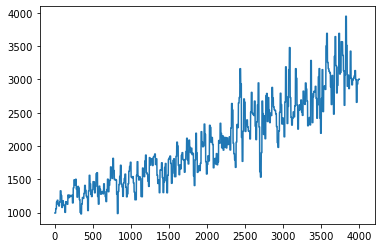

In [18]:
plt.plot(scores_avg)

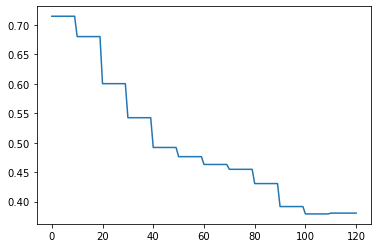

In [14]:
plt.plot(J_avg)